In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["savefig.dpi"] = 300

import seaborn as sns
sns.set_context("paper")

from astropy.table import Table

### Hall et al. 2021 asteroseismic sample

In [4]:
hall = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/NatAs/5.707/table1.dat",
                  readme="https://cdsarc.cds.unistra.fr/ftp/J/other/NatAs/5.707/ReadMe",
                  format="ascii.cds")

hall.info()

<Table length=94>
   name    dtype      unit                         description                     
--------- ------- ------------ ----------------------------------------------------
    Index   int64                                          [0/93] Sequential number
      KIC   int64                                   Kepler Input Catalog identifier
     Teff   int64            K                                Effective temperature
   e_Teff   int64            K                              rms uncertainty on Teff
      Age float64          Gyr                                                  Age
    e_Age float64          Gyr                           Error on Age (lower value)
    E_Age float64          Gyr                           Error on Age (upper value)
     Mass float64         Msun                                                 Mass
   e_Mass float64         Msun                          Error on Mass (lower value)
   E_Mass float64         Msun                          Er

### Curtis et al. 2020 gyrochrones

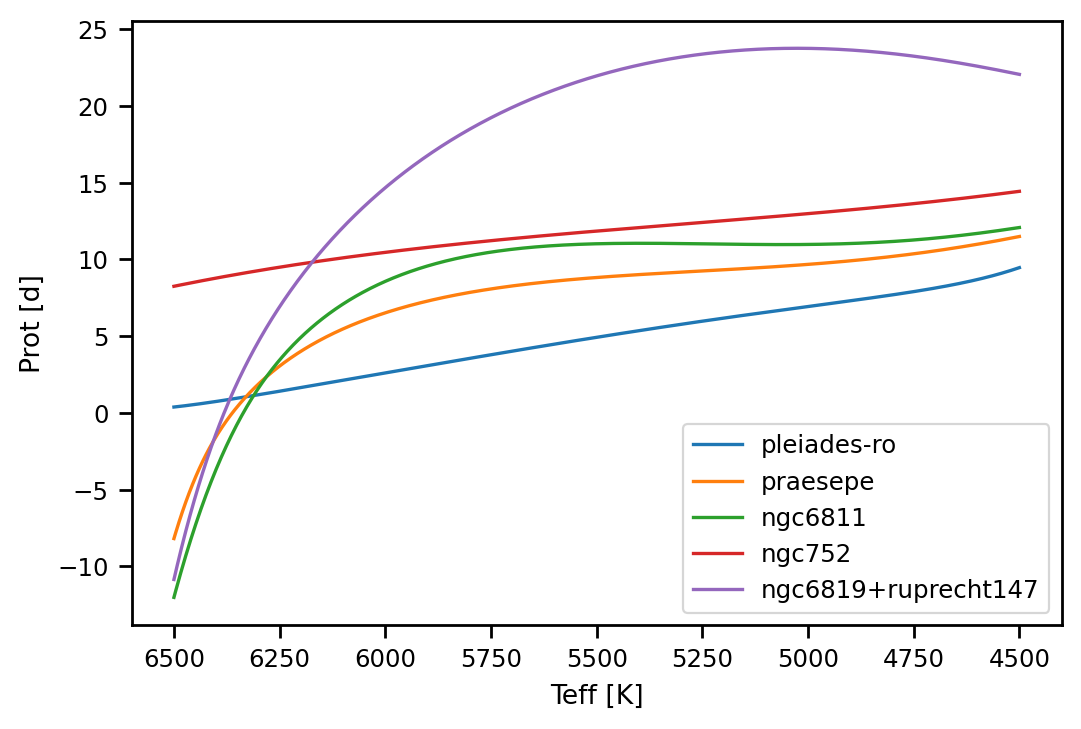

In [5]:
# Curtis et al. 2020 table
def curtis_bprp_teff(bprp):
    #Estimating effective temperature from the dereddened Gaia DR2 (Bp-Rp) color
    bprp  = np.array(bprp)
    coeff = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5, -2694.76, 192.865]    
    teff  = np.array([np.sum([co*_bprp**i for i,co in enumerate(coeff)]) for _bprp in bprp])
    mask  = (bprp>=0.55) & (bprp<=3.25)
    teff[~mask] = np.nan
    return teff

def curtis_gyrochrone(bprp, kind):
    bprp = np.array(bprp)
    
    if kind=='kepler': #Kepler lower envelope
        bprp_min, bprp_max = 0.6, 2.1
        coeff = [36.4756, -202.718, 414.752, -395.161, 197.800, -50.0287, 5.05738]
        
    elif kind=='pleiades-ro':
        bprp_min, bprp_max = 0.6, 1.3
        coeff = [37.068, -188.02, 332.32, -235.78, 60.395]

    elif kind=='pleiades-quad':
        bprp_min, bprp_max = 0.6, 1.3
        coeff = [-8.467, 19.64, -5.438]
        
    elif kind=='praesepe':
        bprp_min, bprp_max = 0.6, 2.4
        coeff = [-330.810, 1462.48, -2569.35, 2347.13, -1171.90, 303.620, -31.9227]
        
    elif kind=='ngc6811':
        bprp_min, bprp_max = 0.65, 1.95 
        coeff = [-594.019, 2671.90, -4791.80, 4462.64, -2276.40, 603.772, -65.0830]
        
    elif kind=='ngc752':
        bprp_min, bprp_max = 1.32, 2.24
        coeff = [6.80, 5.63] 
    
    elif kind=='ngc6819+ruprecht147':
        bprp_min, bprp_max = 0.62, 2.07
        coeff = [-271.783, 932.879, -1148.51, 695.539, -210.562, 25.8119]
        
    prot  = np.array([np.sum([co*_bprp**i for i,co in enumerate(coeff)]) for _bprp in bprp])
    mask  = (bprp>=bprp_min) & (bprp<=bprp_max)
    prot[~mask] = np.nan
    
    return prot
        

#Re-casting the Curtis et al. 2020 polynomial relations in Teff

from scipy import interpolate

def curtis_teff_gyrochrone(teff, kind):
    
    _bprp = np.linspace(0,5,10000)
    _teff = curtis_bprp_teff(_bprp)
    _prot = curtis_gyrochrone(_bprp, kind)
    
    _ = (np.isfinite(_teff)) & (np.isfinite(_prot))
    
    # Be cognizant that using "extrapolate" means the resulting relations will be unreliable
    # outside the Teff ranges over which they were derived, but for our purposes it is effective 
    f = interpolate.interp1d(_teff[_], _prot[_], kind='cubic', fill_value='extrapolate')
    
    return f(teff)


def curtis_teff_bprp(teff):
    #Invert Teff-BpRp relation
    
    _bprp = np.linspace(0.55,3.25,10000)
    _teff = curtis_bprp_teff(_bprp)
    
    _ = (np.isfinite(_teff)) & (np.isfinite(_bprp))
    
    # Be cognizant that using "extrapolate" means the resulting relations will be unreliable
    # outside the Teff ranges over which they were derived, but for our purposes it is effective 
    f = interpolate.interp1d(_teff[_], _bprp[_], kind='cubic', fill_value='extrapolate')
    
    return f(teff)


sequences = ['pleiades-ro', 'praesepe', 'ngc6811', 'ngc752', 'ngc6819+ruprecht147']

_teff = np.linspace(4500,6500,1000)

for seq in sequences:
    plt.plot(_teff, curtis_teff_gyrochrone(_teff, kind=seq), label=seq)

plt.legend()
plt.xlabel('Teff [K]')
plt.ylabel('Prot [d]')
plt.gca().invert_xaxis()    
plt.show()

In [723]:
#McQuillan et al. 2013
mcq_koi = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJ/775/L11/table1.dat",
                readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJ/775/L11/ReadMe",
                format="ascii.cds")
#mcq["n_Prot"][mcq["n_Prot"]=='--']='N'
mcq_koi = mcq_koi.to_pandas()
mcq_koi = mcq_koi.add_prefix('mcq_')
mcq_koi.head()

mcq_KOI   mcq_KIC  mcq_Teff  mcq_log(g)  mcq_Rp mcq_---  mcq_Porb  \
0        3  10748390      4766        4.59    4.68     NaN     4.888   
1       12   5812701      6419        4.26   13.40     NaN    17.855   
2       41   6521045      5909        4.28    1.24     NaN     6.887   
3       42   8866102      6170        4.10    2.71     NaN    17.834   
4       44   8845026      6250        3.50    9.61     NaN    66.468   

   mcq_Prot  mcq_e_Prot  mcq_Rvar mcq_Flag  
0    29.472       0.134     11.75        N  
1     1.245       0.124      0.78      NaN  
2    24.988       2.192      0.39      NaN  
3    20.850       0.007      1.12      NaN  
4     3.792       0.907      1.16      NaN

In [724]:
cks = pd.read_parquet('../data/data.parquet')
# The dataframe has a row entry for each KOI, meaning individual star are represented N times
# where N is the number of KOIs detected around that star so we drop duplicates.
print(np.shape(cks))
cks = cks.drop_duplicates(subset=['kepid'], keep='first')


cks = cks.merge(mcq_koi, how='left', left_on='kepid', right_on='mcq_KIC')
print(np.shape(cks))
cks.head()

(9750, 1371)
(8214, 1382)


kepid kepoi_name   kepler_name         ra  ra_err        ra_str  \
0  10797460  K00752.01  Kepler-227 b  291.93423     0.0  19h27m44.22s   
1  10811496  K00753.01          None  297.00482     0.0  19h48m01.16s   
2  10848459  K00754.01          None  285.53461     0.0  19h02m08.31s   
3  10854555  K00755.01  Kepler-664 b  288.75488     0.0  19h15m01.17s   
4  10872983  K00756.01  Kepler-228 d  296.28613     0.0  19h45m08.67s   

         dec  dec_err       dec_str  koi_gmag  ...     mcq_KIC  mcq_Teff  \
0  48.141651      0.0  +48d08m29.9s    15.890  ...  10797460.0    5584.0   
1  48.134129      0.0  +48d08m02.9s    15.943  ...  10811496.0    5648.0   
2  48.285210      0.0  +48d17m06.8s    16.100  ...         NaN       NaN   
3  48.226200      0.0  +48d13m34.3s    16.015  ...  10854555.0    5781.0   
4  48.224670      0.0  +48d13m28.8s    16.234  ...  10872983.0    5787.0   

   mcq_log(g)  mcq_Rp  mcq_---  mcq_Porb  mcq_Prot  mcq_e_Prot  mcq_Rvar  \
0        4.41    2.50      NaN     9.488    24.924       2.799      3.51   
1        4.84    9.00      NaN    19.899     6.884       0.004     15.58   
2         NaN     NaN      NaN       NaN       NaN         NaN       NaN   
3        4.44    2.80      NaN     2.526    20.479       0.435      6.29   
4        4.51    1.56        0     2.567       NaN         NaN       NaN   

   mcq_Flag  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  

[5 rows x 1382 columns]

In [7]:
std = pd.read_csv('../models/standard_model.csv')
roc = pd.read_csv('../models/rocrit_model.csv')

std['flag'] = 'std'
roc['flag'] = 'roc'

model = pd.concat([std, roc], ignore_index=True, sort=True)
model.head()

Age(Gyr)  Mass(Msun)  Prot(days)        Ro      Teff(K) flag
0  2.343081     0.39749    3.132252  0.028923  3425.943077  std
1  1.110579     0.38310    0.769080  0.007271  3426.052848  std
2  1.162998     0.40312    0.830315  0.008025  3429.332363  std
3  1.398936     0.39909    1.067847  0.009989  3425.867537  std
4  2.144391     0.39106    2.477922  0.022913  3425.887204  std

# Kepler-LAMOST cross-match from Jason Curtis

In [589]:
# lam = pd.read_csv('../data/KeplerRot-LAMOST.csv')
# lam.head()

DR2Name      KIC         RA        Dec     Gmag  \
0  Gaia DR2 2050248955672927744  1025986  291.03375  36.771137  10.0570   
1  Gaia DR2 2050236143797351808  1026474  291.14900  36.723814  15.4588   
2  Gaia DR2 2050239511051851136  1027016  291.26684  36.779943  14.1560   
3  Gaia DR2 2051694572946664960  1028018  291.47131  36.799824  12.6811   
4  Gaia DR2 2050252842630106496  1160891  290.92442  36.828289  13.2300   

      BP_RP  parallax       pmra       pmde    rv_gaia  ...    RV_lam  \
0  0.847284  8.899751  11.035857  21.341856 -28.191136  ... -46.90850   
1  1.763920  2.674871  -9.985404  -0.266650   0.000000  ...  -2.69813   
2  1.309410  2.155335   7.265262   2.413423   0.000000  ... -41.71010   
3  0.942397  2.683880   3.401657  -3.017697   0.000000  ... -24.33120   
4  0.998978  0.759593  -1.533261  -5.867885   0.000000  ... -28.71110   

   e_RV_lam  Teff_lam  e_Teff_lam  logg_lam  e_logg_lam   feh_lam  e_feh_lam  \
0   6.96118   5698.99     32.1638   4.44903    0.072994  0.015688   0.046201   
1   1.19917   4337.47     79.0564   4.49049    0.208060 -0.952368   0.128768   
2   3.95126   4869.07     36.1768   4.55736    0.066285 -0.065245   0.044189   
3   6.64940   5542.87     23.4153   4.23589    0.051219 -0.237506   0.036056   
4  12.45940   6773.86     48.3822   3.96572    0.090168 -0.193356   0.057598   

    afe_lam  e_afe_lam  
0 -0.002194   0.026353  
1  0.208172   0.060008  
2  0.065865   0.021973  
3 -0.009684   0.016085  
4  0.140293   0.036440  

[5 rows x 22 columns]

In [570]:
#Variability induced motion table from Makarov+ 2016
vim = Table.read("../data/makarov2016/table1.dat",
                readme="../data/makarov2016/ReadMe",
                format="ascii.cds")

vim = vim.to_pandas()
vim.head()

KIC      RAdeg     DEdeg       F50   Xpix   Ypix     r     AX     AY  \
0  757076  291.03872  36.59813  297380.0  0.003  0.002  0.48  0.994  0.111   
1  757099  291.04307  36.59381   71433.5  0.007  0.039  0.94  0.166 -0.986   
2  757099  291.04307  36.59381   68285.9  0.005  0.019  0.94  0.164 -0.986   
3  757099  291.04307  36.59381   69312.5  0.005  0.018  0.87 -0.183 -0.983   
4  757099  291.04307  36.59381   70295.2  0.008  0.037  0.79  0.183 -0.983   

      ds/dF     PA  Ch   Q  
0  0.000002   50.8  32  17  
1  0.000012  138.0  32   1  
2  0.000004  138.1  56   3  
3  0.000003  158.0  84   4  
4  0.000009  137.0  32   5

In [508]:
vim_kic = np.unique(vim["KIC"])
vim_r   = np.zeros(len(vim_kic))

for i,k in enumerate(vim_kic):
    arg = vim["KIC"] == k
    vim_r[i] = np.nanmean(vim["r"][arg])

In [511]:
new_vim = pd.DataFrame({"vim_kic": vim_kic, "vim_r": vim_r})

In [670]:
lam = pd.read_csv('../data/KeplerRot-LAMOST.csv')
lam.head()

from astropy.table import Table
#Gaia-Kepler cross-match from Megan Bedell
gk = Table.read('../data/kepler_dr2_1arcsec.fits', format='fits')
gk = gk.to_pandas()

ruwe = Table.read('../data/kepler_dr2_1arcsec_ruwe.fits', format='fits')
ruwe = ruwe.to_pandas()
ruwe.head()

#McQuillan et al. 2014
mcq = Table.read('../data/mcquillan2014/table1.dat',
                readme='../data/mcquillan2014/ReadMe',
                format='ascii.cds')
#mcq["n_Prot"][mcq["n_Prot"]=='--']='N'
mcq = mcq.to_pandas()
mcq = mcq.add_prefix('mcq_')


#Mazeh et al. 2015
maz = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJ/801/3/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJ/801/3/ReadMe",
                 format="ascii.cds")

maz = maz.to_pandas()
maz = maz.add_prefix('maz_')

#Lu et al. 2021
l20 = pd.read_parquet('../data/KinageAllKepler.parquet')

#CDPP from Mathur 2017
cdpp = pd.read_csv('../data/Kepler-Q1-Q17-DR25-CDPP3.csv')


#APOKASC catalog from Serenelli et al. 2017
apo = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/ApJS/233/23/table5.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/ApJS/233/23/ReadMe",
                 format="ascii.cds")

apo = apo.to_pandas()
apo = apo.add_prefix("apo_")
#apo.head()


#vim.head()
lam = lam.merge(gk, how='left', left_on="KIC", right_on="kepid")
lam = lam.merge(l20, how='left', left_on="KIC", right_on="l20_KID")
lam = lam.merge(cdpp, how='left', left_on="KIC", right_on="kepid")
lam = lam.merge(new_vim, how='left', left_on="KIC", right_on="vim_kic")
lam = lam.merge(ruwe, how='left', left_on="KIC", right_on="kepid")
lam = lam.merge(mcq, how='left', left_on="KIC", right_on="mcq_KIC")
lam = lam.merge(apo, how='left', left_on="KIC", right_on="apo_KIC")

In [567]:
# rein = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/A+A/560/A4/table.dat",
#                  readme="https://cdsarc.cds.unistra.fr/ftp/J/A+A/560/A4/ReadMe",
#                  format="ascii.cds")

# rein.info()

maz_KOI   maz_KIC  maz_Teff  maz_log(g)  maz_Prot  maz_e_Prot  maz_Rvar  \
0        1  11446443      5713       4.143     70.55       16.47       445   
1        2  10666592      6264       3.790     70.69        6.80       919   
2        3  10748390      4766       4.590     29.31        0.49     12246   
3        5   8554498      5861       4.170     37.23        4.18       237   
4       10   6922244      6213       4.170     82.12       16.05      1245   

    maz_LPH     maz_w  maz_D  maz_N  maz_C  maz_G  maz_T  maz_F  maz_R  \
0  0.362359  0.000000      0      0      0      0      0      0      0   
1  0.542156  0.000000      0      1      0      0      0      0      0   
2  0.607229  0.431926      0      1      0      0      0      0      0   
3  0.082306  0.000000      0      0      0      0      0      0      0   
4  0.350827  0.000000      0      0      0      0      0      0      0   

   maz_M1  maz_M2  
0       1       0  
1       1       0  
2       0       0  
3       1       0  
4       1       0

In [606]:
for c in lam.columns:
    print(c)

DR2Name
KIC
RA
Dec
Gmag
BP_RP
parallax_x
pmra_x
pmde
rv_gaia
erv_gaia
Prot
RV_lam
e_RV_lam
Teff_lam
e_Teff_lam
logg_lam
e_logg_lam
feh_lam
e_feh_lam
afe_lam
e_afe_lam
solution_id
designation
source_id_x
random_index
gaia_ref_epoch
ra
ra_error
dec
dec_error
parallax_y
parallax_error
parallax_over_error
pmra_y
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g

In [607]:
lam["astrometric_matched_observations"]

0        25
1        30
2        28
3        27
4        25
         ..
12216    16
12217    26
12218    26
12219    16
12220    16
Name: astrometric_matched_observations, Length: 12221, dtype: int16

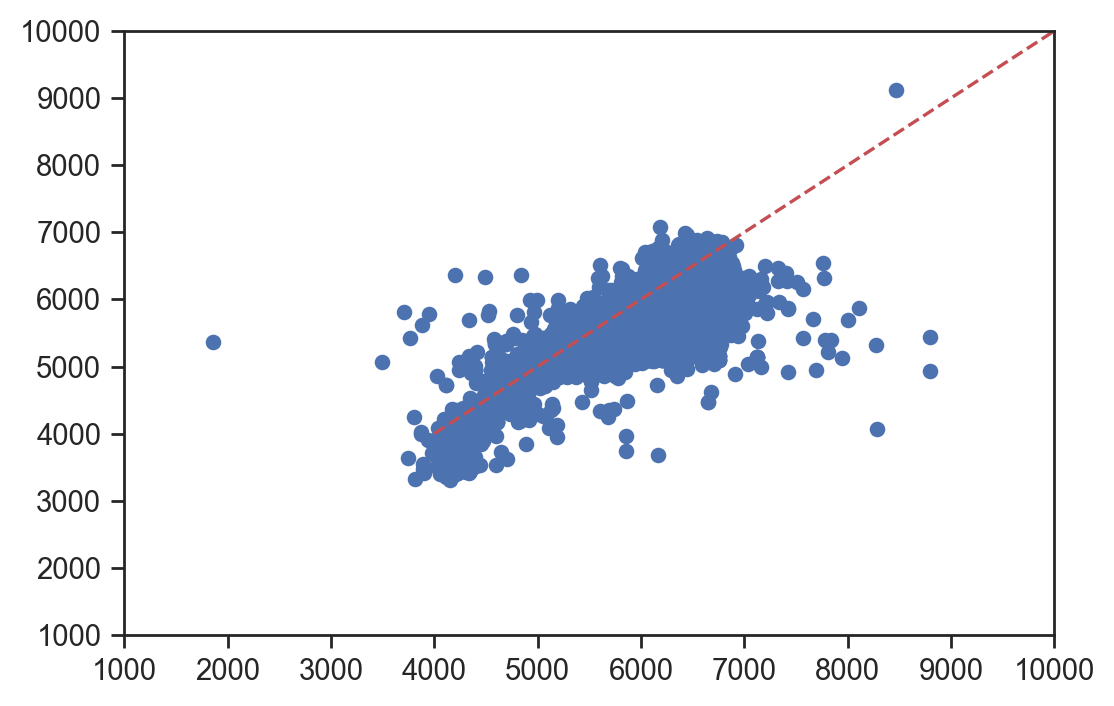

In [596]:
plt.scatter(lam["Teff_lam"], lam["teff_val"])
plt.xlim(1000,10000)
plt.ylim(1000,10000)
plt.plot([4000,10000],[4000,10000],'r--')
plt.show()

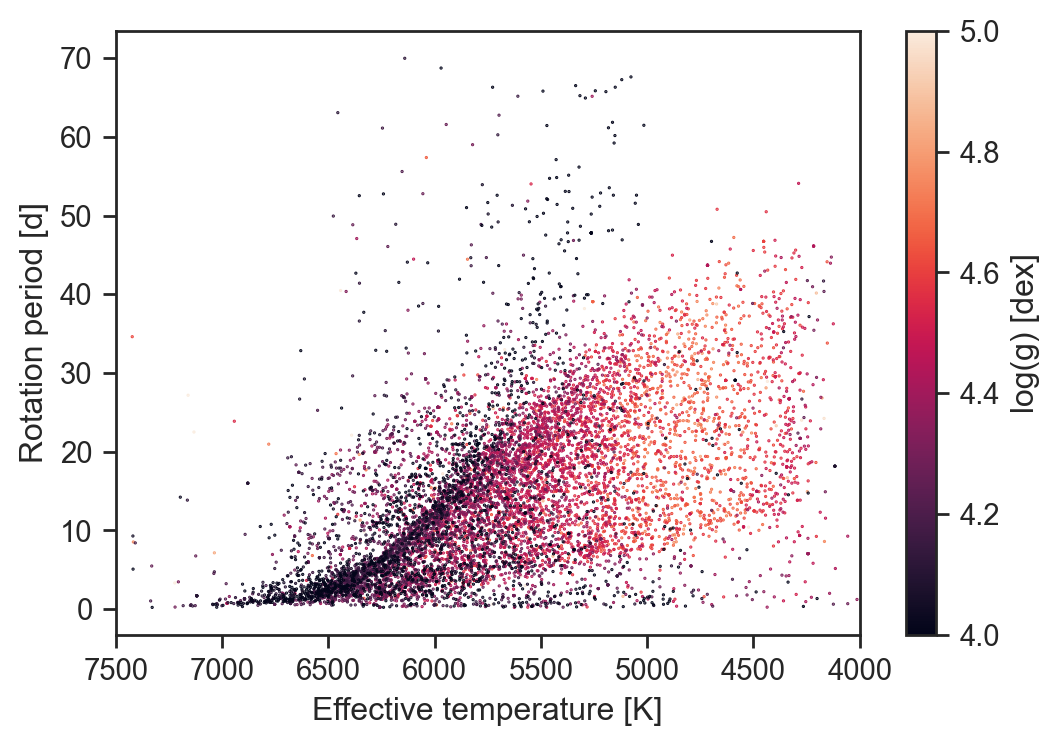

In [627]:
ik = (lam['Teff_lam']>0)
ik &= (lam['Gmag']<15)
#ik &= (lam['l20_Rvar']/lam['rrmscdpp03p0'] > 10)
#ik &= (lam['logg_lam']-3*lam['e_logg_lam']>4)
ik &= (lam['duplicated_source']==False)
#ik &= (abs(lam["Gmag"]-lam["phot_g_mean_mag"])<1)
#ik &= (abs(lam["Gmag"]-lam["kepmag"])<1)
#ik &= (abs(lam["Teff_lam"]-lam["teff_val"])<1000)
#ik &= (lam['parallax_over_error']>50)
#ik &= (lam["vim_r"]<0.5)
#ik &= (lam["ruwe"]<1.2)

x = np.array(lam["Teff_lam"][ik])
y = np.array(lam["Prot"][ik])
z = np.array(lam["logg_lam"][ik])
#z = np.array(lam["feh_lam"][ik])

arg = np.argsort(z)[::-1]
x = x[arg]
y = y[arg]
z = z[arg]

#plt.scatter(lam["Teff_lam"], lam["Prot"], marker=',', s=2)

plt.scatter(x, y, marker='.', s=0.5, c=z, vmin=4, vmax=5)
plt.colorbar(label='log(g) [dex]')
plt.xlabel("Effective temperature [K]")
plt.ylabel("Rotation period [d]")
plt.xlim(7500,4000)
#plt.ylim(0,100)
plt.show()

In [563]:



#np.unique(mcq['n_Prot'])

<Table length=34030>
 name   dtype      unit                                 description                                class     n_bad
------ ------- ------------ ------------------------------------------------------------------- ------------ -----
   KIC   int64                                     Kepler Input Catalog identifier (Cat. V/133)       Column     0
  Teff   int64            K                              [3197/6499] Star effective temperature       Column     0
log(g) float64 dex(cm / s2)                                [3.5/5.4] Star surface gravity (log)       Column     0
  Mass float64         Msun                                             [0.2/1.3] Star mass (1)       Column     0
  Prot float64            d                                           [0.2/70]? Rotation period       Column     0
e_Prot float64            d                                               [0/51]? Error in Prot       Column     0
  Rper float64          ppm         [187/1520000]? Average 

In [ ]:
## kic = np.array(lam["KIC"])
# kic = ["KIC "+str(k) for k in kic]
# tmp = pd.DataFrame({"kic": kic})
# tmp.to_csv('../data/lamost-kic.csv', index=False)

In [ ]:
for c in lam.columns:
    print(c)

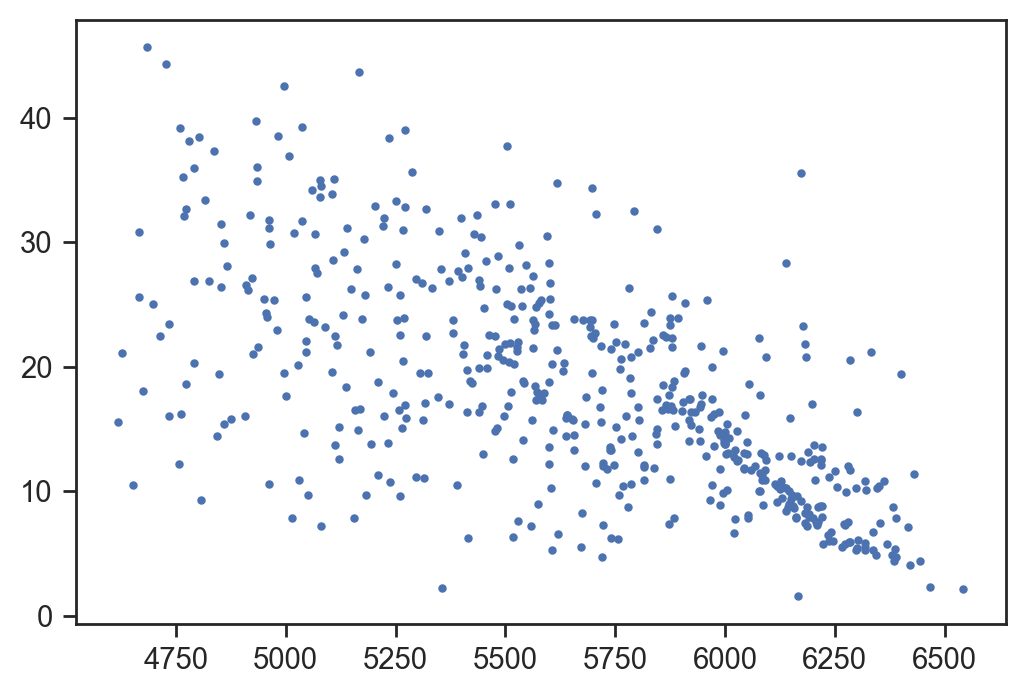

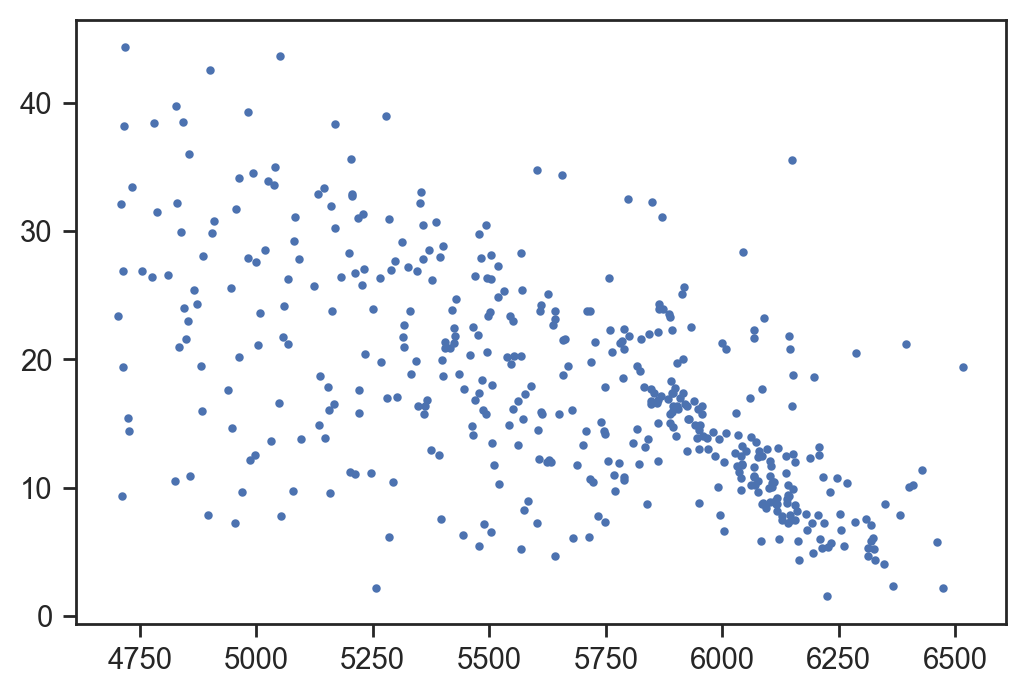

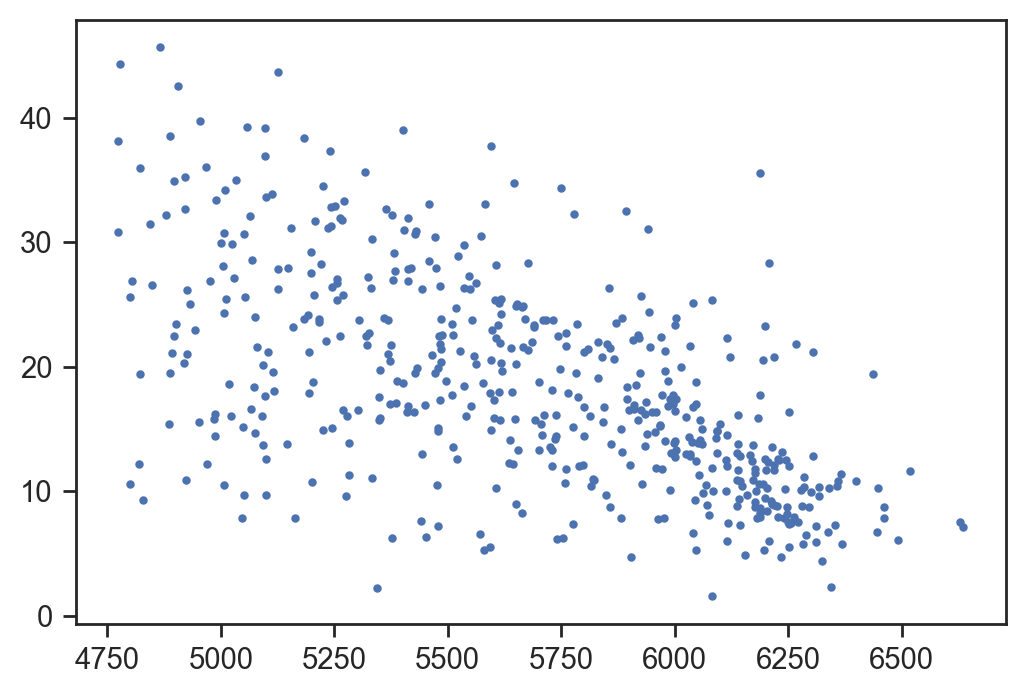

In [128]:
plt.scatter(cks_teff, cks_prot, s=5)
plt.show()
plt.scatter(cks['bf18_Teff'], cks_prot, s=5)
plt.show()
plt.scatter(cks['m19_Teff'], cks_prot, s=5)
plt.show()

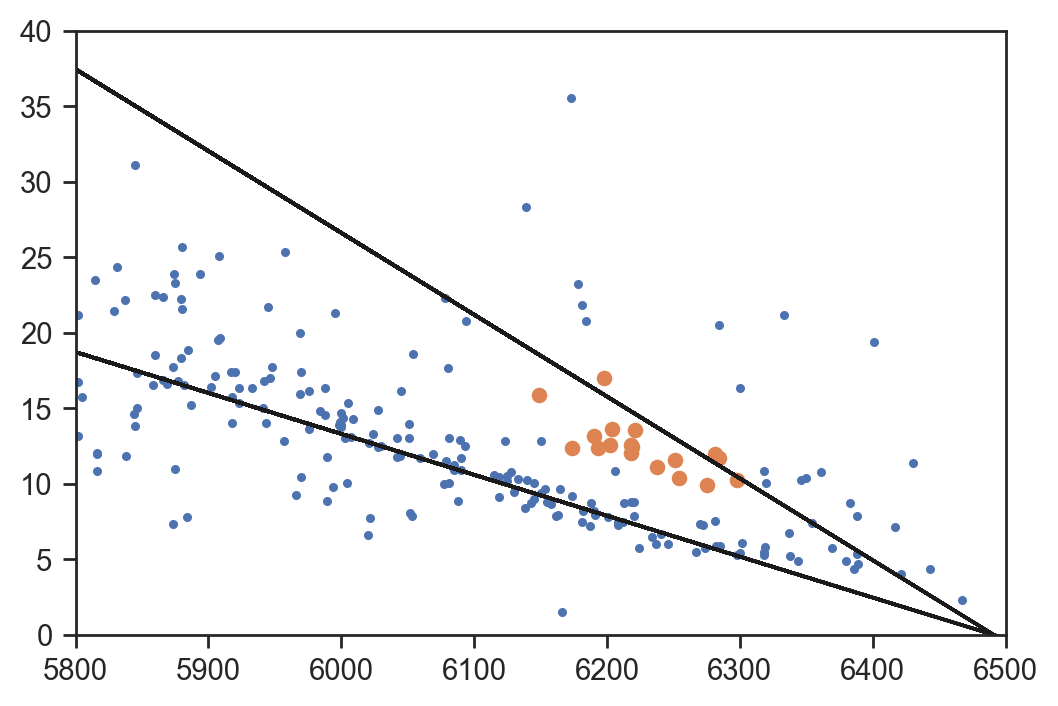

355     K00975.01
491     K01001.01
1272    K01537.01
2062    K02563.01
2314    K02545.01
2321    K02623.01
2346    K02632.01
2518    K00279.01
2654    K02833.01
2822    K03114.01
2845    K03122.01
2944    K03060.01
2950    K00288.01
4043    K04431.01
4063    K04435.01
4383    K04575.01
4446    K04588.01
5291    K03425.01
Name: kepoi_name, dtype: object


In [121]:
#arg = (cks_prot<ridge_hi(cks_teff)) & (cks_teff>6100) & (cks_prot>ridge_lo(cks_teff)) & (cks_teff<6300)
arg = (cks_prot>ridge_hi(cks_teff)) & (cks_teff>6100) & (cks_prot<1.5*ridge_hi(cks_teff)) & (cks_teff<6300)

plt.scatter(cks['cks_Teff'], cks['d21_prot'], label='CKS', **sc_kws)
plt.scatter(cks['cks_Teff'][arg], cks['d21_prot'][arg], label='CKS')
plt.plot(cks_teff, res[1] + res[0]*cks_teff, 'k')
plt.plot(cks_teff, 2* (res[1] + res[0]*cks_teff), 'k')
plt.xlim(5800,6500)
plt.ylim(0,40)
plt.show()

print(cks['kepoi_name'][arg])

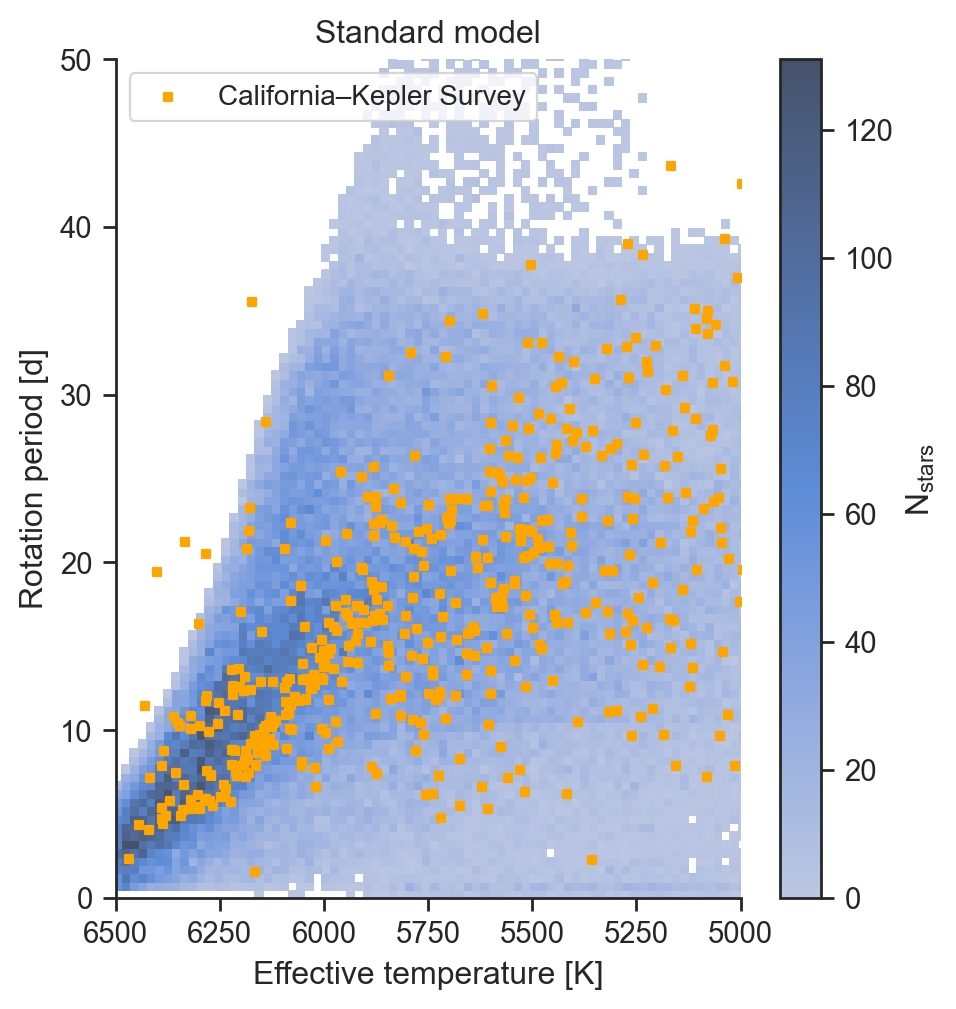

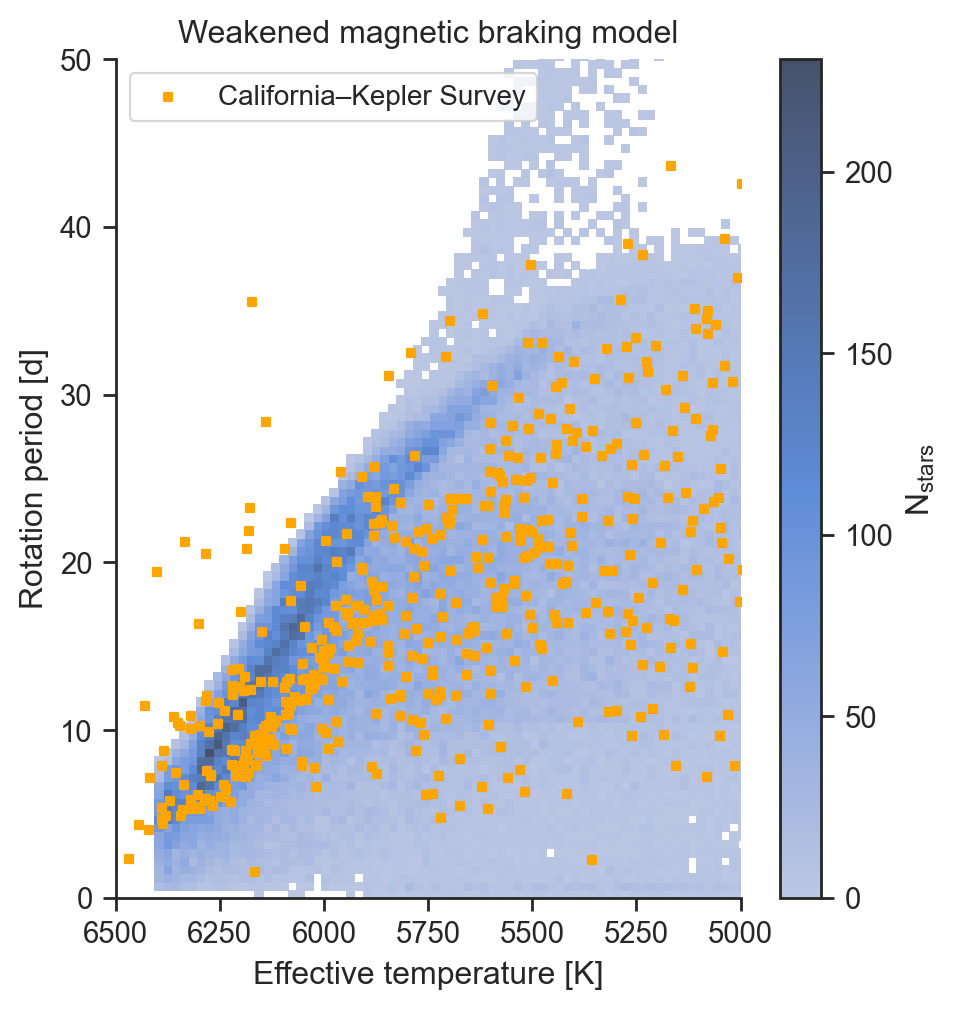

In [135]:
mpl.rcParams["legend.markerscale"] = 1
sns.set(font_scale=1.2, context="paper", style="ticks")
sc_kws = {"marker":",", "color":"orange", "s":8, "rasterized":True}

sns.displot(data=std, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(cks['cks_Teff'], cks['d21_prot'], label='California–Kepler Survey', **sc_kws)

# gyro_sequences = ['pleiades-ro', 'praesepe', 'ngc6811', 'ngc6819+ruprecht147']
# _teff = np.linspace(4500,6500,1000)

# for seq in gyro_sequences:
#     plt.plot(_teff, curtis_teff_gyrochrone(_teff, kind=seq), label=seq, color='k', lw=1)

plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Standard model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/std-model-cks.pdf')
plt.show()


sns.displot(data=roc, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(cks['cks_Teff'], cks['d21_prot'], label='California–Kepler Survey', **sc_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Weakened magnetic braking model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/wmb-model-cks.pdf')
plt.show()

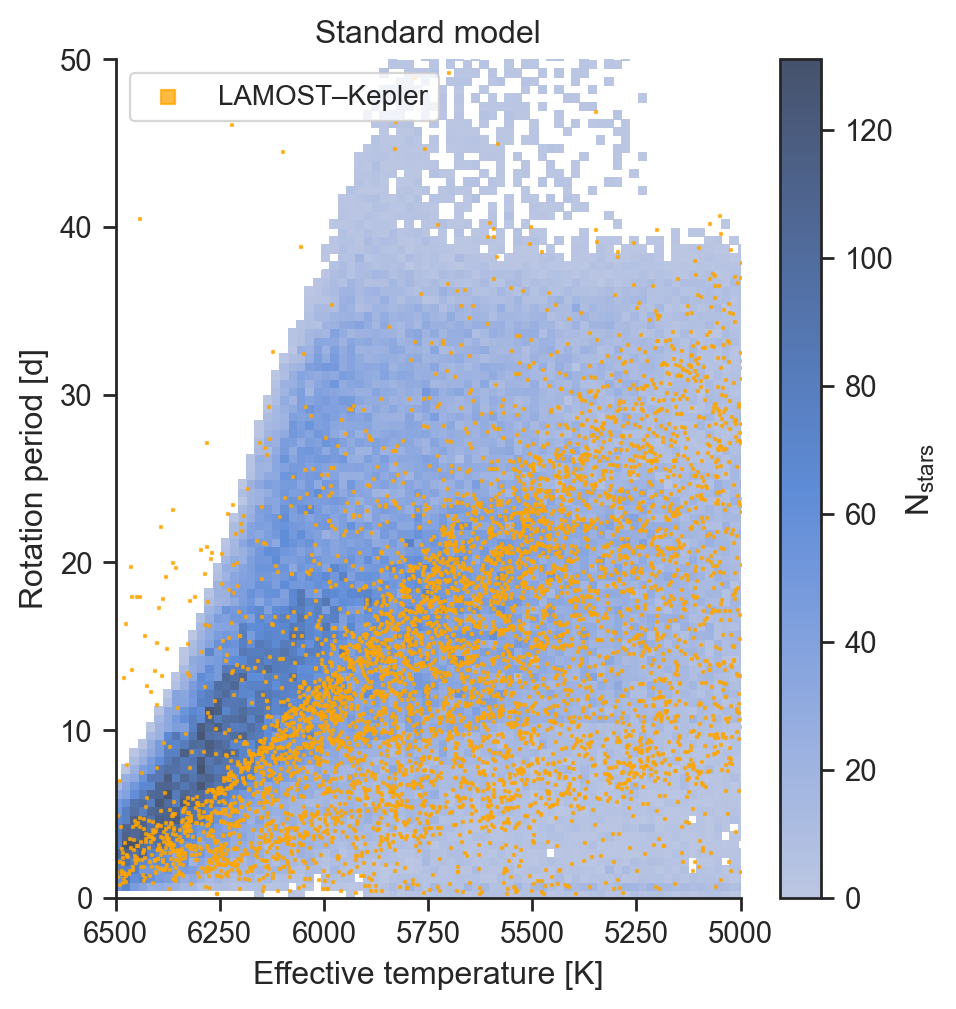

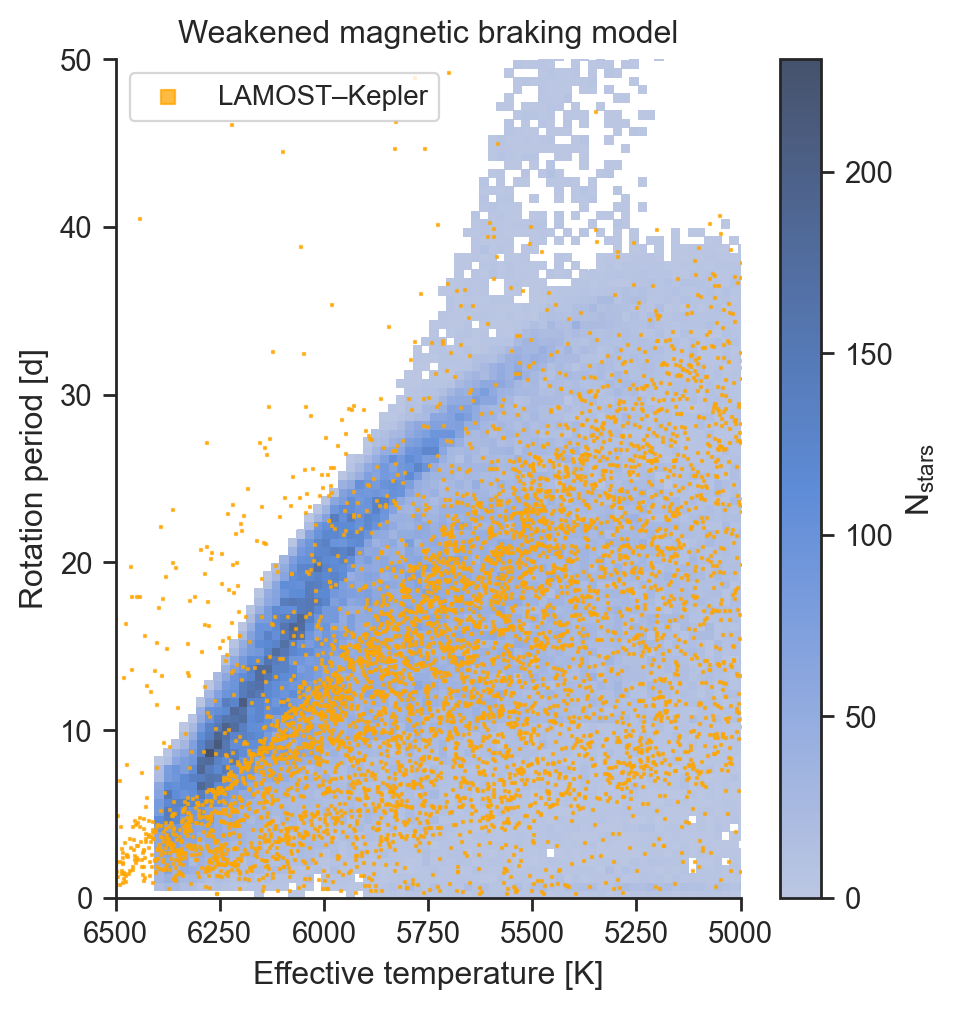

In [136]:
mpl.rcParams["legend.markerscale"] = 5
sns.set(font_scale=1.2, context="paper", style="ticks")
sc_kws = {"marker":",", "color":"orange", "s":1, "rasterized":True, "alpha":0.75}

sns.displot(data=std, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(lam['Teff_lam'][ik], lam['Prot'][ik], label='LAMOST–Kepler', **sc_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Standard model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/std-model-lamost.pdf')
plt.show()

sns.displot(data=roc, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(lam['Teff_lam'][ik], lam['Prot'][ik], label='LAMOST–Kepler', **sc_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Weakened magnetic braking model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/wmb-model-lamost.pdf')
plt.show()

In [153]:
# for c in hall.columns:
#     print(c)
    
np.unique(hall["Flag"])
for i in range(4):
    print(len(hall[hall["Flag"]==i]))

73
16
3
2


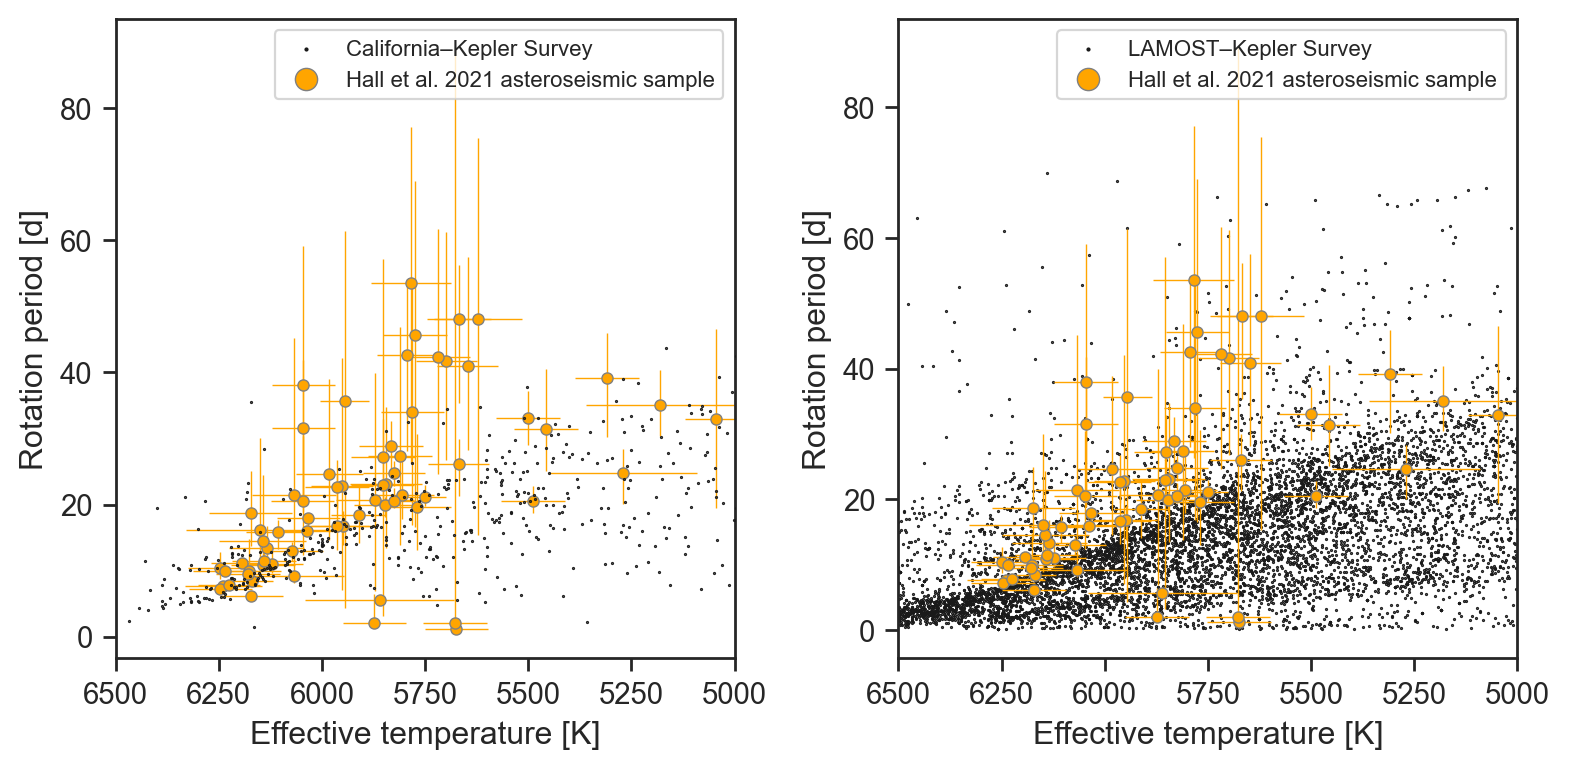

In [633]:
sns.set(font_scale=1.2, context="paper", style="ticks")

mpl.rcParams["legend.markerscale"] = 2
titles = ["California–Kepler Survey","LAMOST–Kepler Survey"]
ebar_kws = {"fmt":"o", "lw":0.5, "ms": 4, "ecolor":"orange", "color":"orange", "alpha":1, "mec":"grey", "mew":0.5}
sc_kws = {"marker":".", "color":"k", "s":0.5, "rasterized":True, "alpha":1}

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,4))

ax[0].scatter(cks["p20_cks_steff"], cks["d21_prot"], **sc_kws, label=r"California–Kepler Survey", zorder=999)
ax[1].scatter(lam['Teff_lam'][ik], lam['Prot'][ik], **sc_kws, label=r"LAMOST–Kepler Survey")

for i in range(2):
    arg = hall["Type"] == "MS"
    ax[i].errorbar(hall["Teff"][arg], hall["P"][arg], 
                   xerr=hall["e_Teff"][arg], 
                   yerr=[hall["e_P"][arg], hall["E_P"][arg]], 
                   label="Hall et al. 2021 asteroseismic sample",
                   **ebar_kws)
    ax[i].set_xlim(6500,5000)
    ax[i].set_xlabel("Effective temperature [K]")
    ax[i].set_ylabel("Rotation period [d]")
    #ax[i].set_title(titles[i])
    ax[i].legend(prop={"size":8})
    
plt.tight_layout()
#plt.savefig('../figures/asteroseismic.pdf')
plt.show()

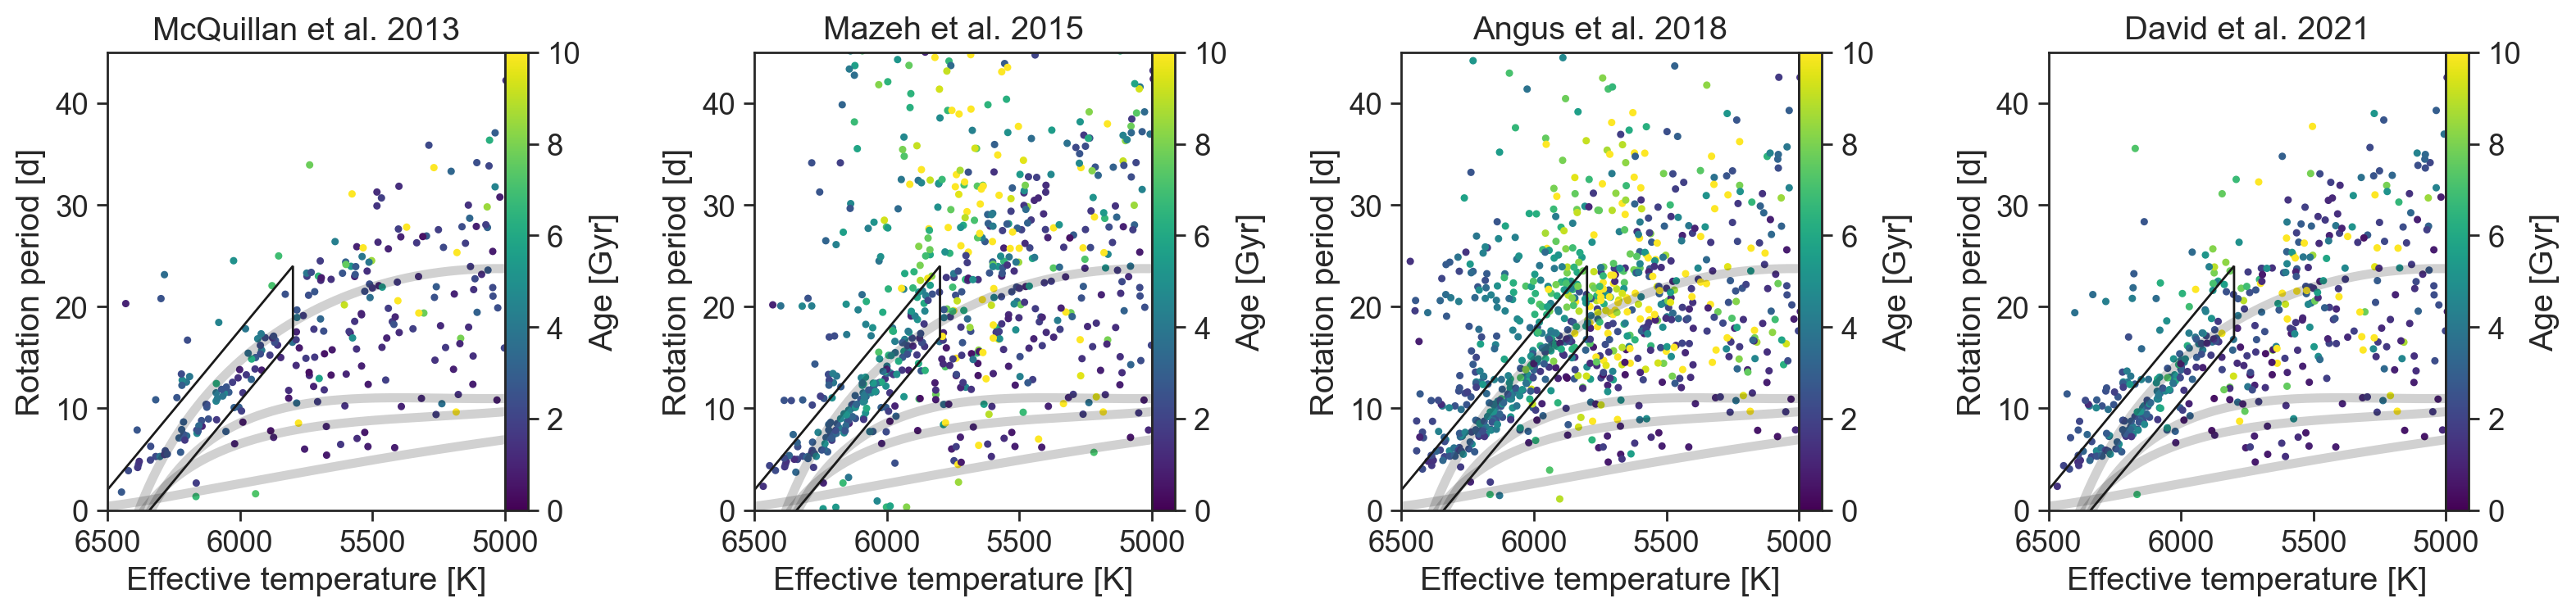

In [635]:
import matplotlib.patches as patches
sns.set(font_scale=1.5, context="paper", style="ticks")

def ridge_hi(teff):
    m = (2-24)/(6500-5800)
    b = (2 - m*6500) 
    return m*teff + b

def ridge_lo(teff):
    m = (2-24)/(6500-5800)
    b = (-5 - m*6500) 
    return m*teff + b


mask = (cks['p20_cks_slogg']>4) #main sequence

ridge = (cks['p20_cks_steff']>5850)
ridge &= (cks['p20_cks_steff']<6500)
ridge &= (cks['d21_prot']<ridge_hi(cks['p20_cks_steff']))
ridge &= (cks['d21_prot']>ridge_lo(cks['p20_cks_steff']))
#ridge &= mask

# Parallelogram
xp = [6500,6500,5800,5800]
yp = [ridge_lo(6500),ridge_hi(6500),ridge_hi(5800),ridge_lo(5800)]




x = cks['cks_Teff']
ys = [cks['m13_Prot'], cks['m15_Prot'], cks['a18_period'], cks['d21_prot']]
labels = ['McQuillan et al. 2013','Mazeh et al. 2015', 'Angus et al. 2018','David et al. 2021']

sc_kws = {'cmap':'viridis', 's':6, 'vmin':0, 'vmax':10, 'alpha':1, 'rasterized':True}

gyro_sequences = ['pleiades-ro', 'praesepe', 'ngc6811', 'ngc6819+ruprecht147']

fig, ax = plt.subplots(nrows=1, ncols=len(ys), figsize=(0.8*20,0.8*5))

for i,y in enumerate(ys):
    sc1 = ax[i].scatter(x[mask], y[mask], c=cks['cks_age'][mask], **sc_kws)
    
    cb1 = fig.colorbar(sc1, ax=ax[i], pad=0)
    #cb2 = fig.colorbar(sc2, ax=ax[1][i], pad=0)    
    
    ax[i].set_title(labels[i])
    ax[i].set_ylim(0,45)
    ax[i].set_xlim(6500,5000)
    #ax[i].invert_xaxis()
    ax[i].set_ylabel('Rotation period [d]')
    ax[i].set_xlabel('Effective temperature [K]')
    cb1.set_label('Age [Gyr]')
    
    
    #if i==4:
    #    cb1.set_label('[Y/Mg] Age [Gyr]')
        #cb2.set_label('[Y/Mg] Age [Gyr]')
       
    _teff = np.linspace(4500,6500,1000)

    for seq in gyro_sequences:
        ax[i].plot(_teff, curtis_teff_gyrochrone(_teff, kind=seq), label=seq, color='k', lw=4, alpha=0.2)
        
        
    #Parallelogram
    ax[i].add_patch(patches.Polygon(xy=list(zip(xp,yp)), fill=False, lw=1, color='k'))
    
plt.tight_layout()
#plt.savefig('../figures/ridge.pdf')
plt.show()

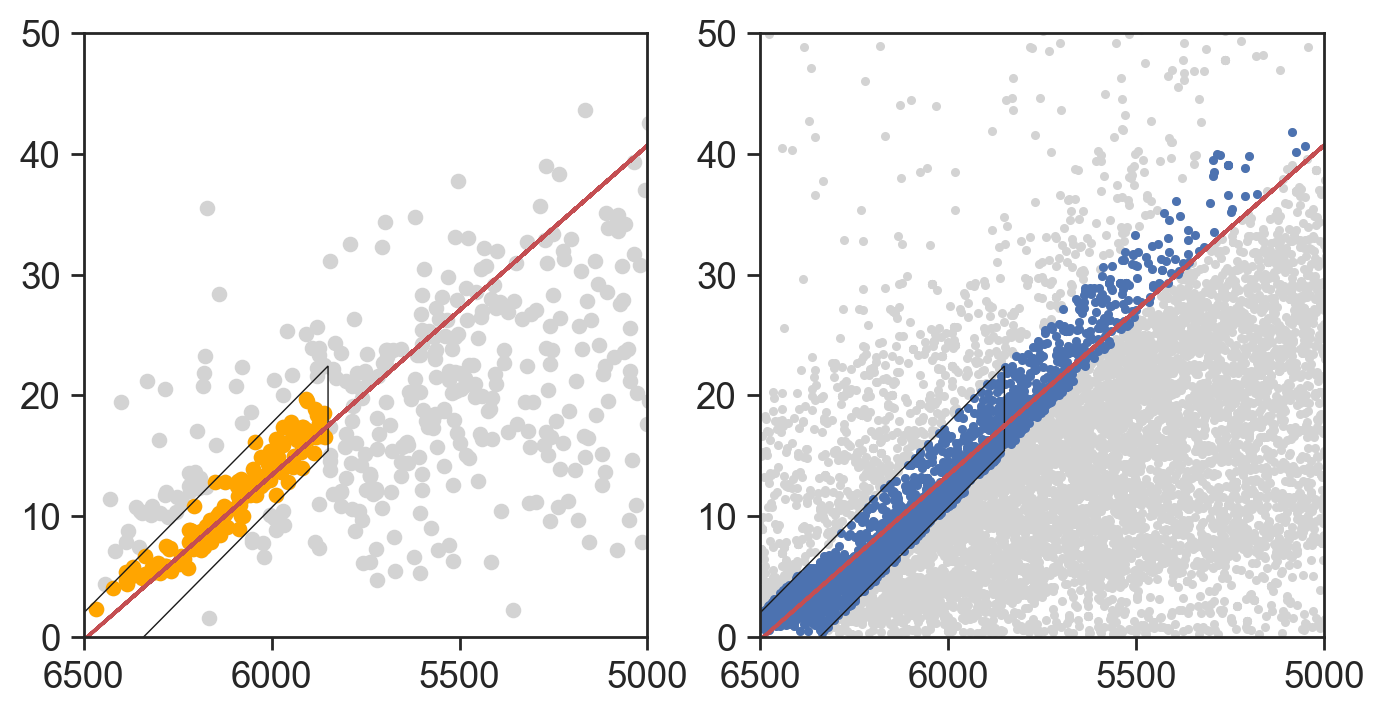

In [637]:
cks_teff = cks["p20_cks_steff"]
cks_e_teff = cks["p20_cks_steff_err1"]
cks_prot = cks["d21_prot"]

lam_teff = lam["Teff_lam"]
lam_e_teff = lam["e_Teff_lam"]
lam_prot = lam["Prot"]


def ridge_hi(teff):
    m = (2-24)/(6500-5800)
    b = (2 - m*6500) 
    return m*teff + b

def ridge_lo(teff):
    m = (2-24)/(6500-5800)
    b = (-5 - m*6500) 
    return m*teff + b


#lam_ridge = lam["logg_lam"]>4
#lam_ridge &= (lam["Teff_lam"]>5850)
#lam_ridge &= (lam["Teff_lam"]<6500)
lam_ridge = (lam["Prot"]<ridge_hi(lam["Teff_lam"]))
lam_ridge &= (lam["Prot"]>ridge_lo(lam["Teff_lam"]))



# ridge = (cks['p20_cks_steff']>5850)
# ridge &= (cks['p20_cks_steff']<6500)
# ridge &= (cks['d21_prot']<ridge_hi(cks['p20_cks_steff']))
# ridge &= (cks['d21_prot']>ridge_lo(cks['p20_cks_steff']))
# ridge &= mask

fig,ax = plt.subplots(ncols=2, figsize=(8,4))

#ax.scatter(cks['p20_cks_steff'], cks['a18_period'], color='lightgrey', alpha=0.2)
ax[0].scatter(cks['p20_cks_steff'], cks['d21_prot'], color='lightgrey', alpha=1)
ax[0].scatter(cks['p20_cks_steff'][ridge], cks['d21_prot'][ridge], alpha=1, color='orange')

from scipy import stats
m = (cks_teff<5750) & (np.isfinite(cks_teff)) & (np.isfinite(cks_prot))
res = stats.theilslopes(cks_prot[ridge], cks_teff[ridge], 0.90)

ax[0].plot(cks_teff, res[1] + res[0]*cks_teff, 'r')
ax[1].plot(cks_teff, res[1] + res[0]*cks_teff, 'r')

for i in range(2):
    # Parallelogram
    x = [6500,6500,5850,5850]
    y = [ridge_lo(6500),ridge_hi(6500),ridge_hi(5850),ridge_lo(5850)]
    ax[i].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, lw=0.5, color='k'))
    ax[i].invert_xaxis()
    ax[i].set_xlim(6500,5000)
    ax[i].set_ylim(0,50)

ax[1].scatter(lam_teff, lam_prot, color='lightgrey', **sc_kws)
ax[1].scatter(lam_teff[lam_ridge], lam_prot[lam_ridge], **sc_kws)
    
#ax.plot(_teff, ridge_hi(_teff), 'k--')
#ax.plot(_teff, ridge_lo(_teff), 'k--')
plt.show()

In [93]:
res

(nan, nan, nan, nan)

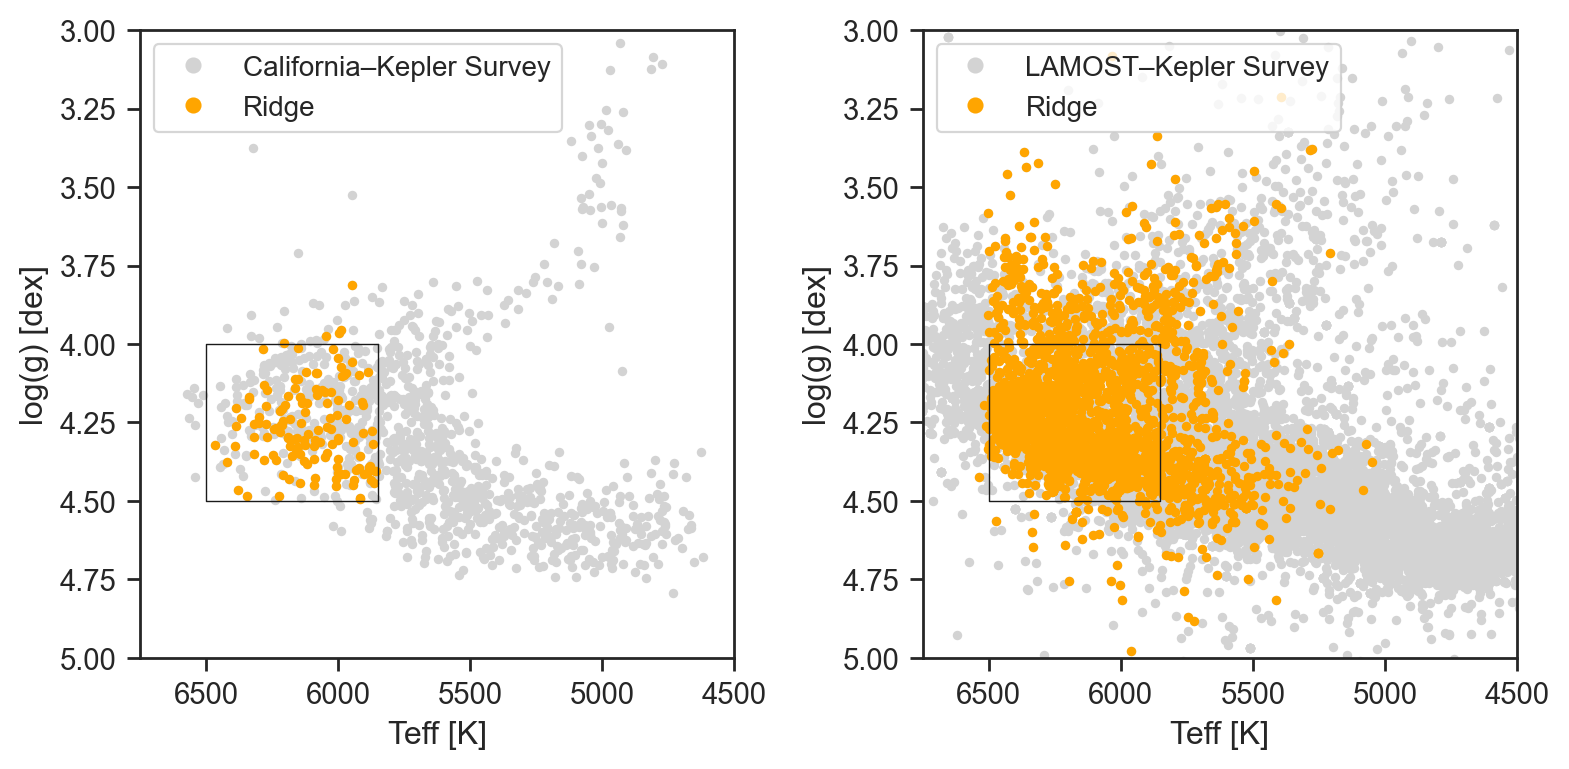

In [638]:
sns.set(font_scale=1.2, context="paper", style="ticks")



mpl.rcParams["legend.markerscale"] = 2

all_f = mask & (cks['p20_cks_steff']>5800) & (cks['p20_cks_slogg']<4.5) & (cks['p20_cks_steff']<6500)

fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,4))

ax[0].plot(cks['p20_cks_steff'], cks['p20_cks_slogg'], '.', color='lightgrey', label='California–Kepler Survey')
#ax.plot(cks['p20_cks_steff'][all_f], cks['p20_cks_slogg'][all_f], 'o', color='lightgrey', mec='k')
#ax.plot(cks['p20_cks_steff'][all_f], cks['p20_cks_slogg'][all_f], 'o', color='lightgrey', ms=3)
ax[0].plot(cks['p20_cks_steff'][ridge], cks['p20_cks_slogg'][ridge], '.', color='orange', label='Ridge')
#ax[0].invert_yaxis()
#ax[0].invert_xaxis()



ax[1].plot(lam['Teff_lam'], lam['logg_lam'], 
           '.', color='lightgrey', label='LAMOST–Kepler Survey')
ax[1].plot(lam['Teff_lam'][lam_ridge], lam['logg_lam'][lam_ridge], 
           '.', color='orange', label='Ridge')

for i in range(2):
    ax[i].plot([5850,6500,6500,5850,5850],[4.,4.,4.5,4.5,4.],color='k',lw=0.5)
    ax[i].set_xlim(6750,4500)
    ax[i].set_ylim(5,3)
    ax[i].set_ylabel('log(g) [dex]')
    ax[i].set_xlabel('Teff [K]')    
    ax[i].legend(prop={'size':10}, loc='upper left')

plt.tight_layout()
plt.show()

/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

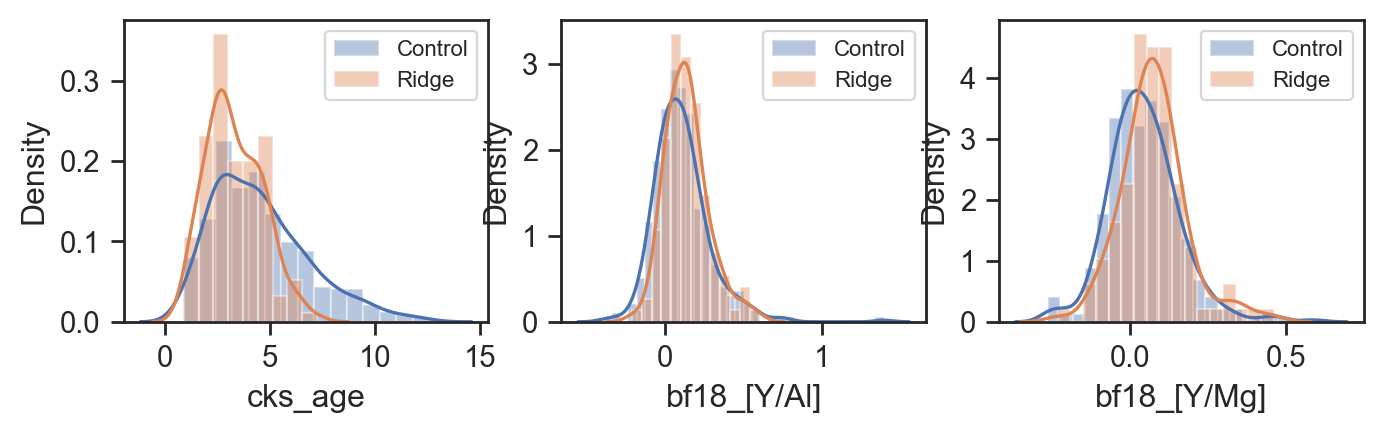

In [639]:
all_f = mask & (cks['p20_cks_steff']>5800) & (cks['p20_cks_slogg']<4.5) & (cks['p20_cks_steff']<6500)



fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(8,2))


sns.distplot(cks['cks_age'][all_f], label='Control', ax=ax1)
sns.distplot(cks['cks_age'][ridge], label='Ridge', ax=ax1)

sns.distplot(cks['bf18_[Y/Al]'][all_f], label='Control', ax=ax2)
sns.distplot(cks['bf18_[Y/Al]'][ridge], label='Ridge', ax=ax2)

sns.distplot(cks['bf18_[Y/Mg]'][all_f], label='Control', ax=ax3)
sns.distplot(cks['bf18_[Y/Mg]'][ridge], label='Ridge', ax=ax3)


for ax in [ax1,ax2,ax3]:
    ax.legend(prop={'size':8})

# plt.xlabel('Age [Gyr]')
# plt.legend()
# plt.show()

# plt.xlabel('[Y/Al]')
# plt.legend()
# plt.show()

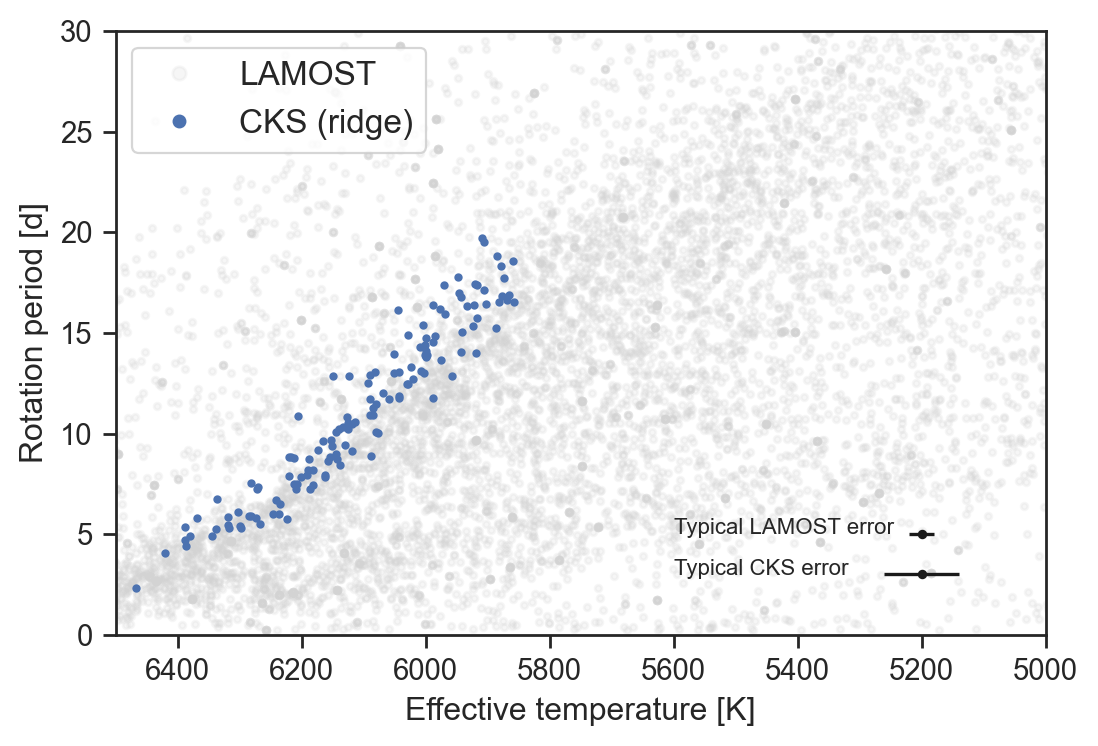

In [640]:
plt.plot(lam['Teff_lam'][ik], lam['Prot'][ik], '.', alpha=0.2, color='lightgrey', label='LAMOST', rasterized=True)
plt.plot(cks['p20_cks_steff'][ridge], cks['d21_prot'][ridge], 'o', ms=2, label='CKS (ridge)', rasterized=True)
plt.errorbar(5200,3,xerr=np.nanmedian(cks['p20_cks_steff_err1']),yerr=0,fmt='.',color='k', zorder=999)
plt.errorbar(5200,5,xerr=np.nanmedian(lam['e_Teff_lam'][lam['Teff_lam']>5800]),yerr=0,fmt='.',color='k', zorder=999)
plt.text(5600, 3, 'Typical CKS error', size=8)
plt.text(5600, 5, 'Typical LAMOST error', size=8)
plt.xlim(6500,5000)
plt.ylim(0,30)
plt.legend(prop={"size":12})
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
#plt.savefig('../figures/cks-lamost.pdf')
plt.show()

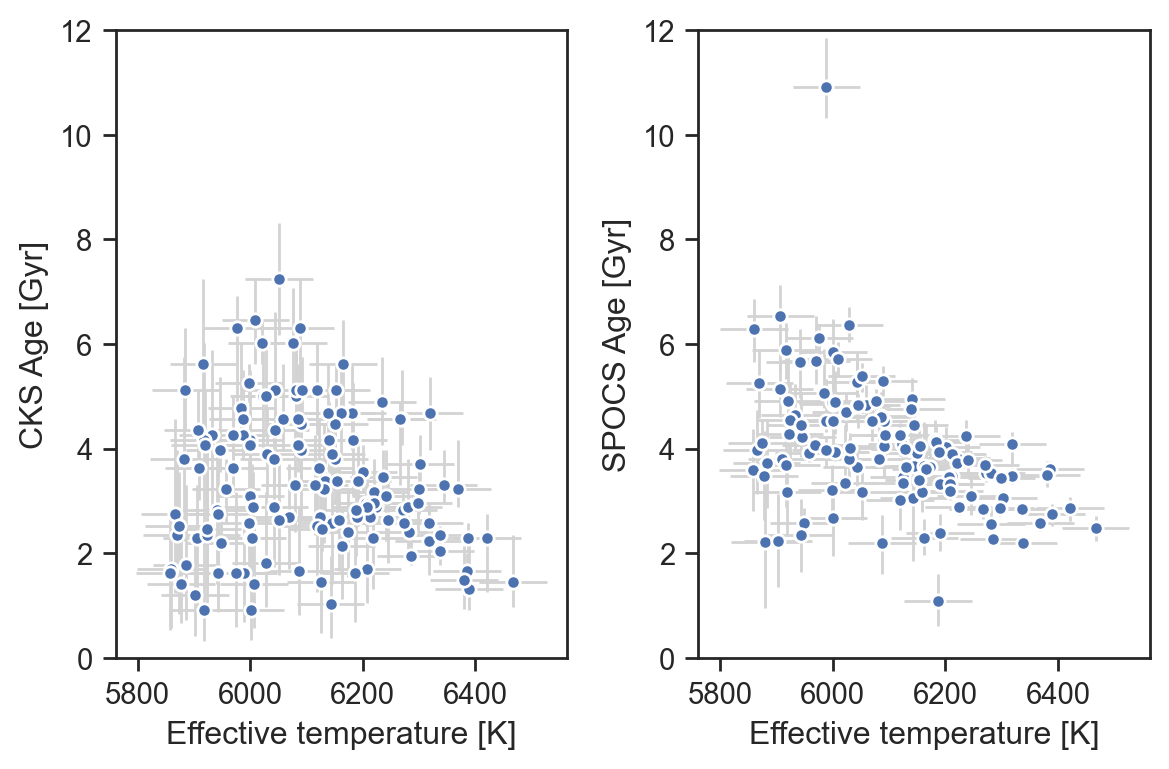

[1.4355691  5.62341325]
[2.299 5.842]


In [641]:
cks['cks_e_age'] = cks['cks_age'] - (10.**(cks['cks_logAiso']-cks['cks_e_logAiso'])/1.0e9)
cks['cks_E_age'] = (10.**(cks['cks_logAiso']+cks['cks_E_logAiso'])/1.0e9) - cks['cks_age']

sns.set(font_scale=1.2, context="paper", style="ticks")

fig, ax = plt.subplots(nrows=1,ncols=2)


ax[0].errorbar(cks['p20_cks_steff'][ridge], cks['cks_age'][ridge], 
             xerr=[cks['cks_e_Teff'][ridge], cks['cks_E_Teff'][ridge]],
             yerr=[cks['cks_e_age'][ridge], cks['cks_E_age'][ridge]], fmt='o', mec='white', linewidth=1, ecolor='lightgrey')
ax[0].set_ylabel('CKS Age [Gyr]')
ax[0].set_xlabel('Effective temperature [K]')

ax[1].errorbar(cks['p20_cks_steff'][ridge], cks['bf18_Age'][ridge], 
             xerr=[cks['cks_e_Teff'][ridge], cks['cks_E_Teff'][ridge]],
             yerr=[cks['bf18_e_Age'][ridge], cks['bf18_E_Age'][ridge]], fmt='o', mec='white', linewidth=1, ecolor='lightgrey')
ax[1].set_ylabel('SPOCS Age [Gyr]')
ax[1].set_xlabel('Effective temperature [K]')

for i in range(2):
    ax[i].set_ylim(0,12)
    
plt.tight_layout()
#plt.savefig('../figures/age-teff.pdf')
plt.show()

print(np.nanpercentile(cks['cks_age'][ridge], [5,95]))
print(np.nanpercentile(cks['bf18_Age'][ridge], [5,95]))

In [645]:
# tmp1 = list(lam["KIC"])
# tmp2 = list(cks["kepid"][np.isfinite(cks["cks_Teff"])])

# def intersection(lst1, lst2):
#     lst3 = [value for value in lst1 if value in lst2]
#     return lst3

# len(intersection(tmp1, tmp2))

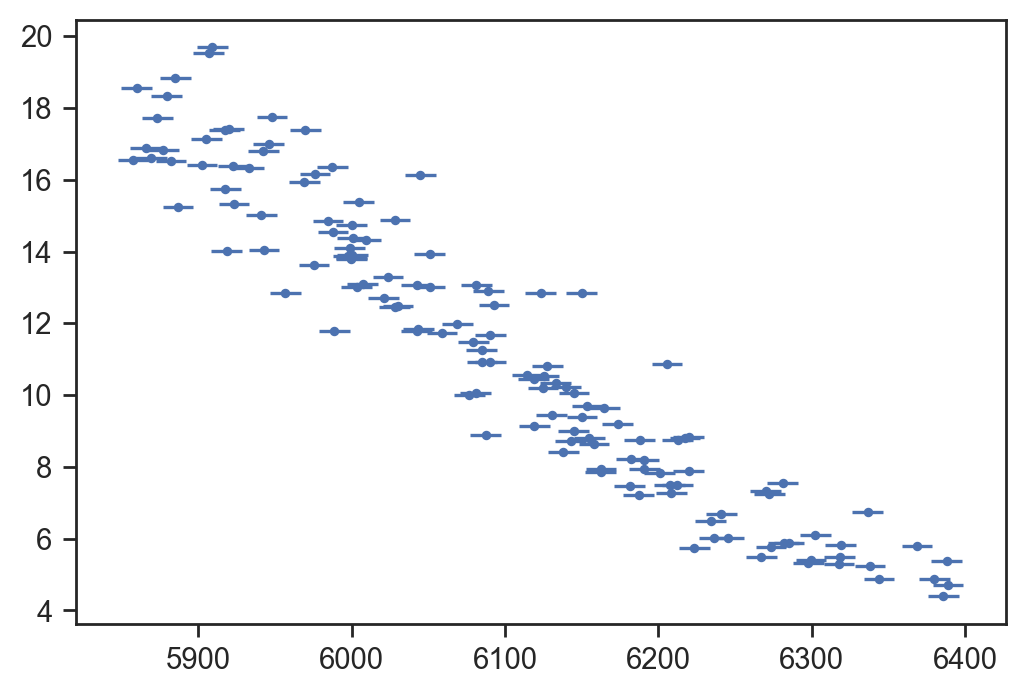

In [646]:
x = np.array(cks_teff[ridge])
y = np.array(cks_prot[ridge])

arg = x<6400
x = x[arg]
y = y[arg]

y = y[np.argsort(x)]
x = np.sort(x)

xerr = 10*np.ones(len(x))
yerr = 1*np.ones(len(y))

plt.errorbar(x, y, xerr=xerr, fmt='.')
plt.show()

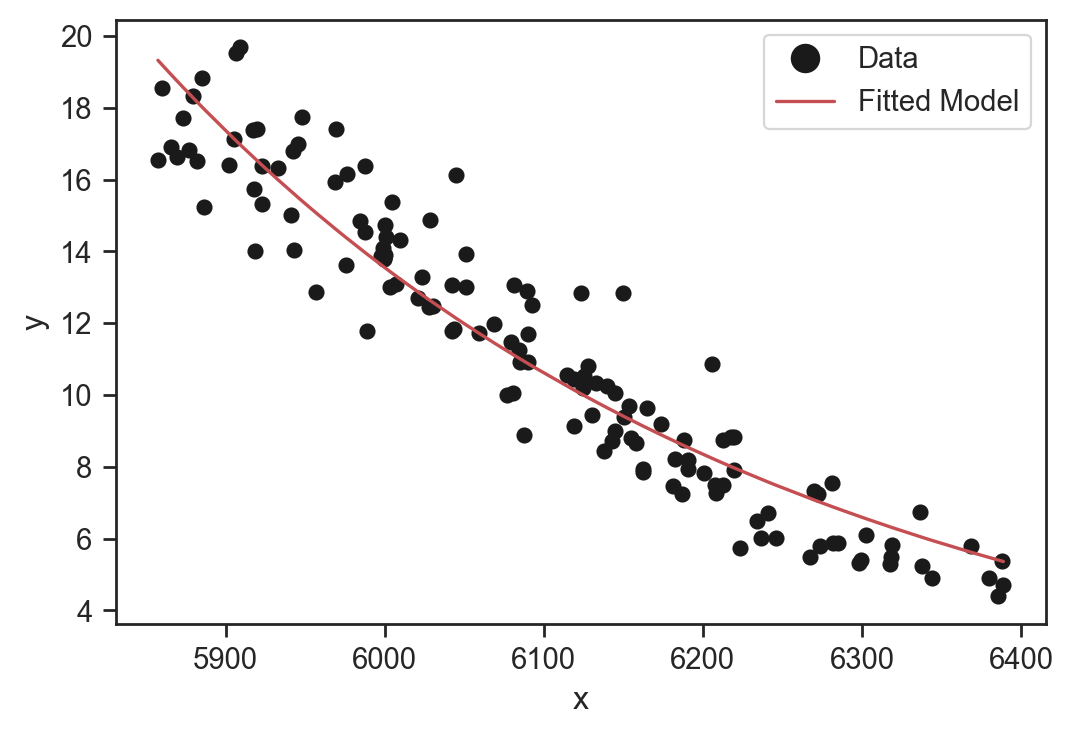

In [647]:
from astropy.modeling.powerlaws import BrokenPowerLaw1D
from astropy.modeling import models, fitting

fit = fitting.LevMarLSQFitter()
bplaw_init = BrokenPowerLaw1D()

#fit = BrokenPowerLaw1D(amplitude=1, x_break=1, alpha_1=1, alpha_2=1)
fitted_bplaw = fit(bplaw_init, x, y)


# plot the model
plt.figure()
plt.plot(x, y, 'ko', label='Data')
plt.plot(x, fitted_bplaw(x), 'r-', label='Fitted Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

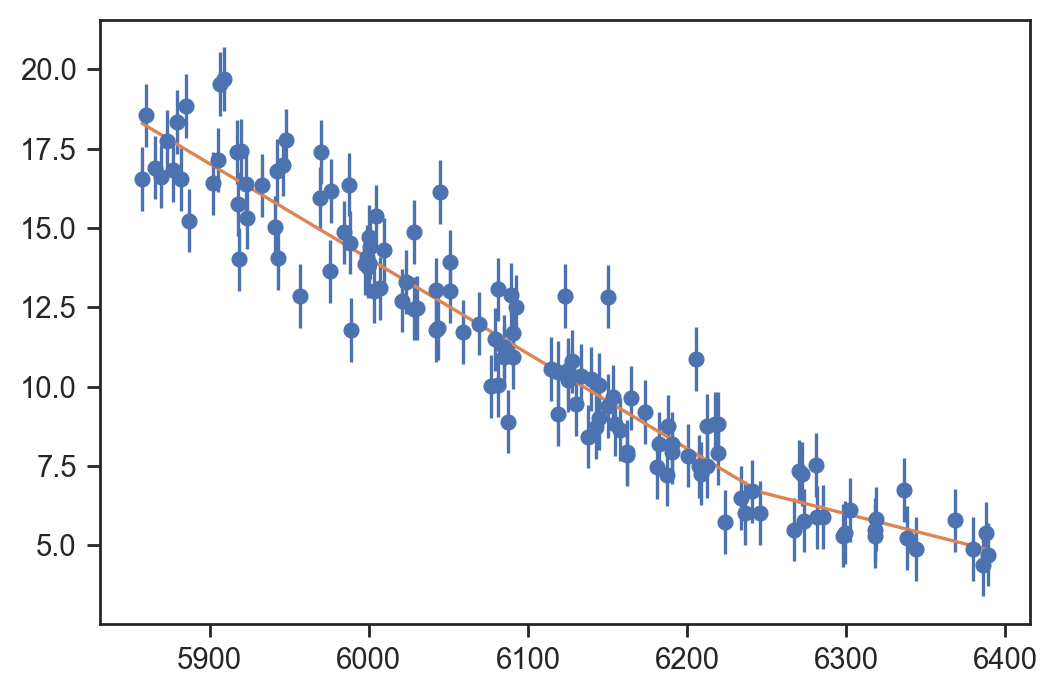

In [648]:
from scipy.optimize import curve_fit

def piecewise_linear(x, x0, y0, k1, k2):
    y = np.piecewise(x, [x < x0, x >= x0],
                     [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    return y


popt_piecewise, pcov = curve_fit(piecewise_linear, x, y, p0=[6250, 7,5 -0.025, 0.025])

new_x = np.linspace(x.min(), x.max(), 61)


fig, ax = plt.subplots()

ax.errorbar(x, y, yerr=1, fmt='o')
ax.plot(new_x, piecewise_linear(new_x, *popt_piecewise))
plt.show()

In [649]:
def piecewise_linear(x, x0, y0, k1, k2):
    y = np.piecewise(x, [x < x0, x >= x0],
                     [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    return y

def log_likelihood(theta, x, y, yerr):
    x0, y0, k1, k2, f = theta
    #x0, y0, k1, k2 = theta
    model = piecewise_linear(x, x0, y0, k1, k2)
    #sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    sigma2 = yerr ** 2 + model ** 2 * f ** 2
    #sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    x0, y0, k1, k2, f = theta
    #x0, y0, k1, k2 = theta
    #if 6150 < x0 < 6350 and 0 < y0 < 10 and -1 < k1 < 1 and -1 < k2 < 1 and -10.0 < log_f < 1.0:
    if 6150 < x0 < 6350 and 0 < y0 < 10 and -1 < k1 < 1 and -1 < k2 < 1 and 0 < f < 10:
    #if 6150 < x0 < 6350 and 0 < y0 < 10 and -1 < k1 < 1 and -1 < k2 < 1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [650]:
import emcee

popt_piecewise = np.append(popt_piecewise, 0.1)

pos = popt_piecewise + 1e-4 * np.random.randn(32, len(popt_piecewise))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:09<00:00, 516.52it/s]


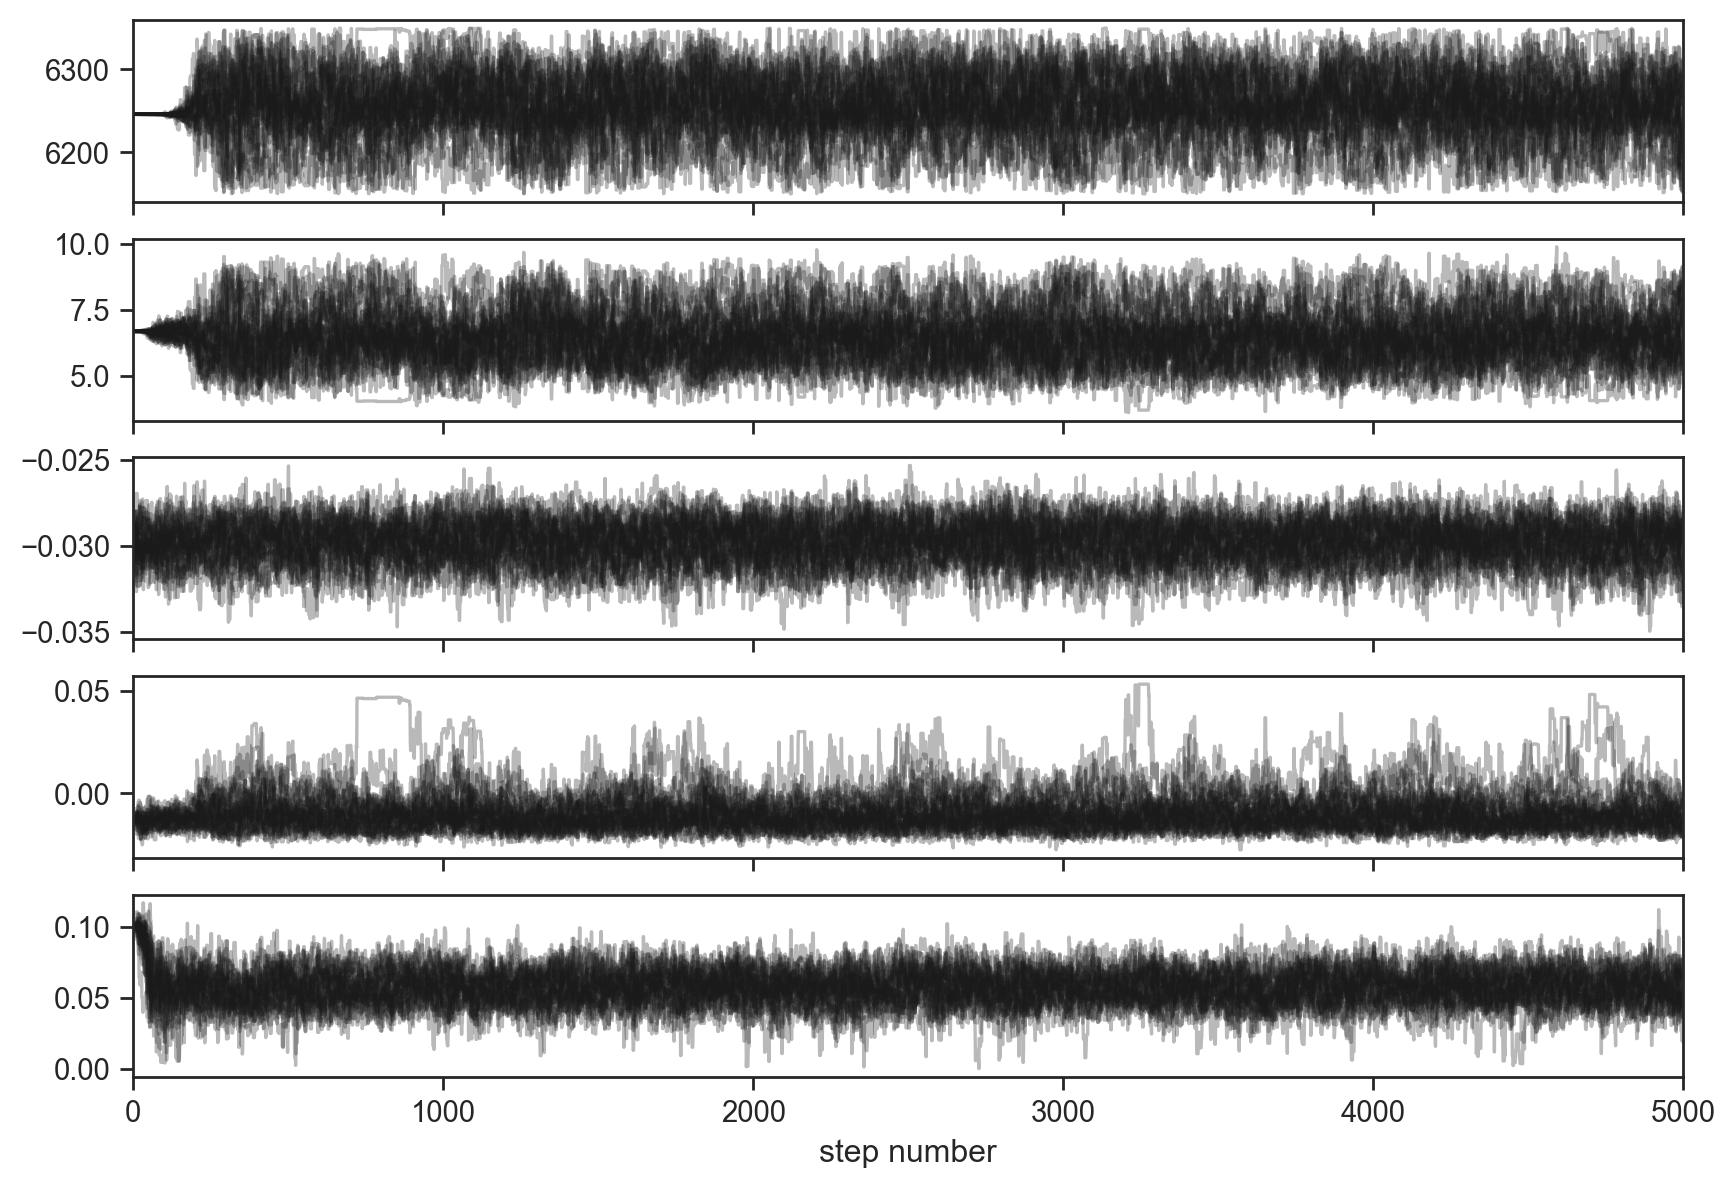

In [651]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
#labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    #ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [652]:
tau = sampler.get_autocorr_time()
print(tau)

flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

[77.84036145 78.20196098 61.98803855 84.96283234 56.39477494]
(10432, 5)


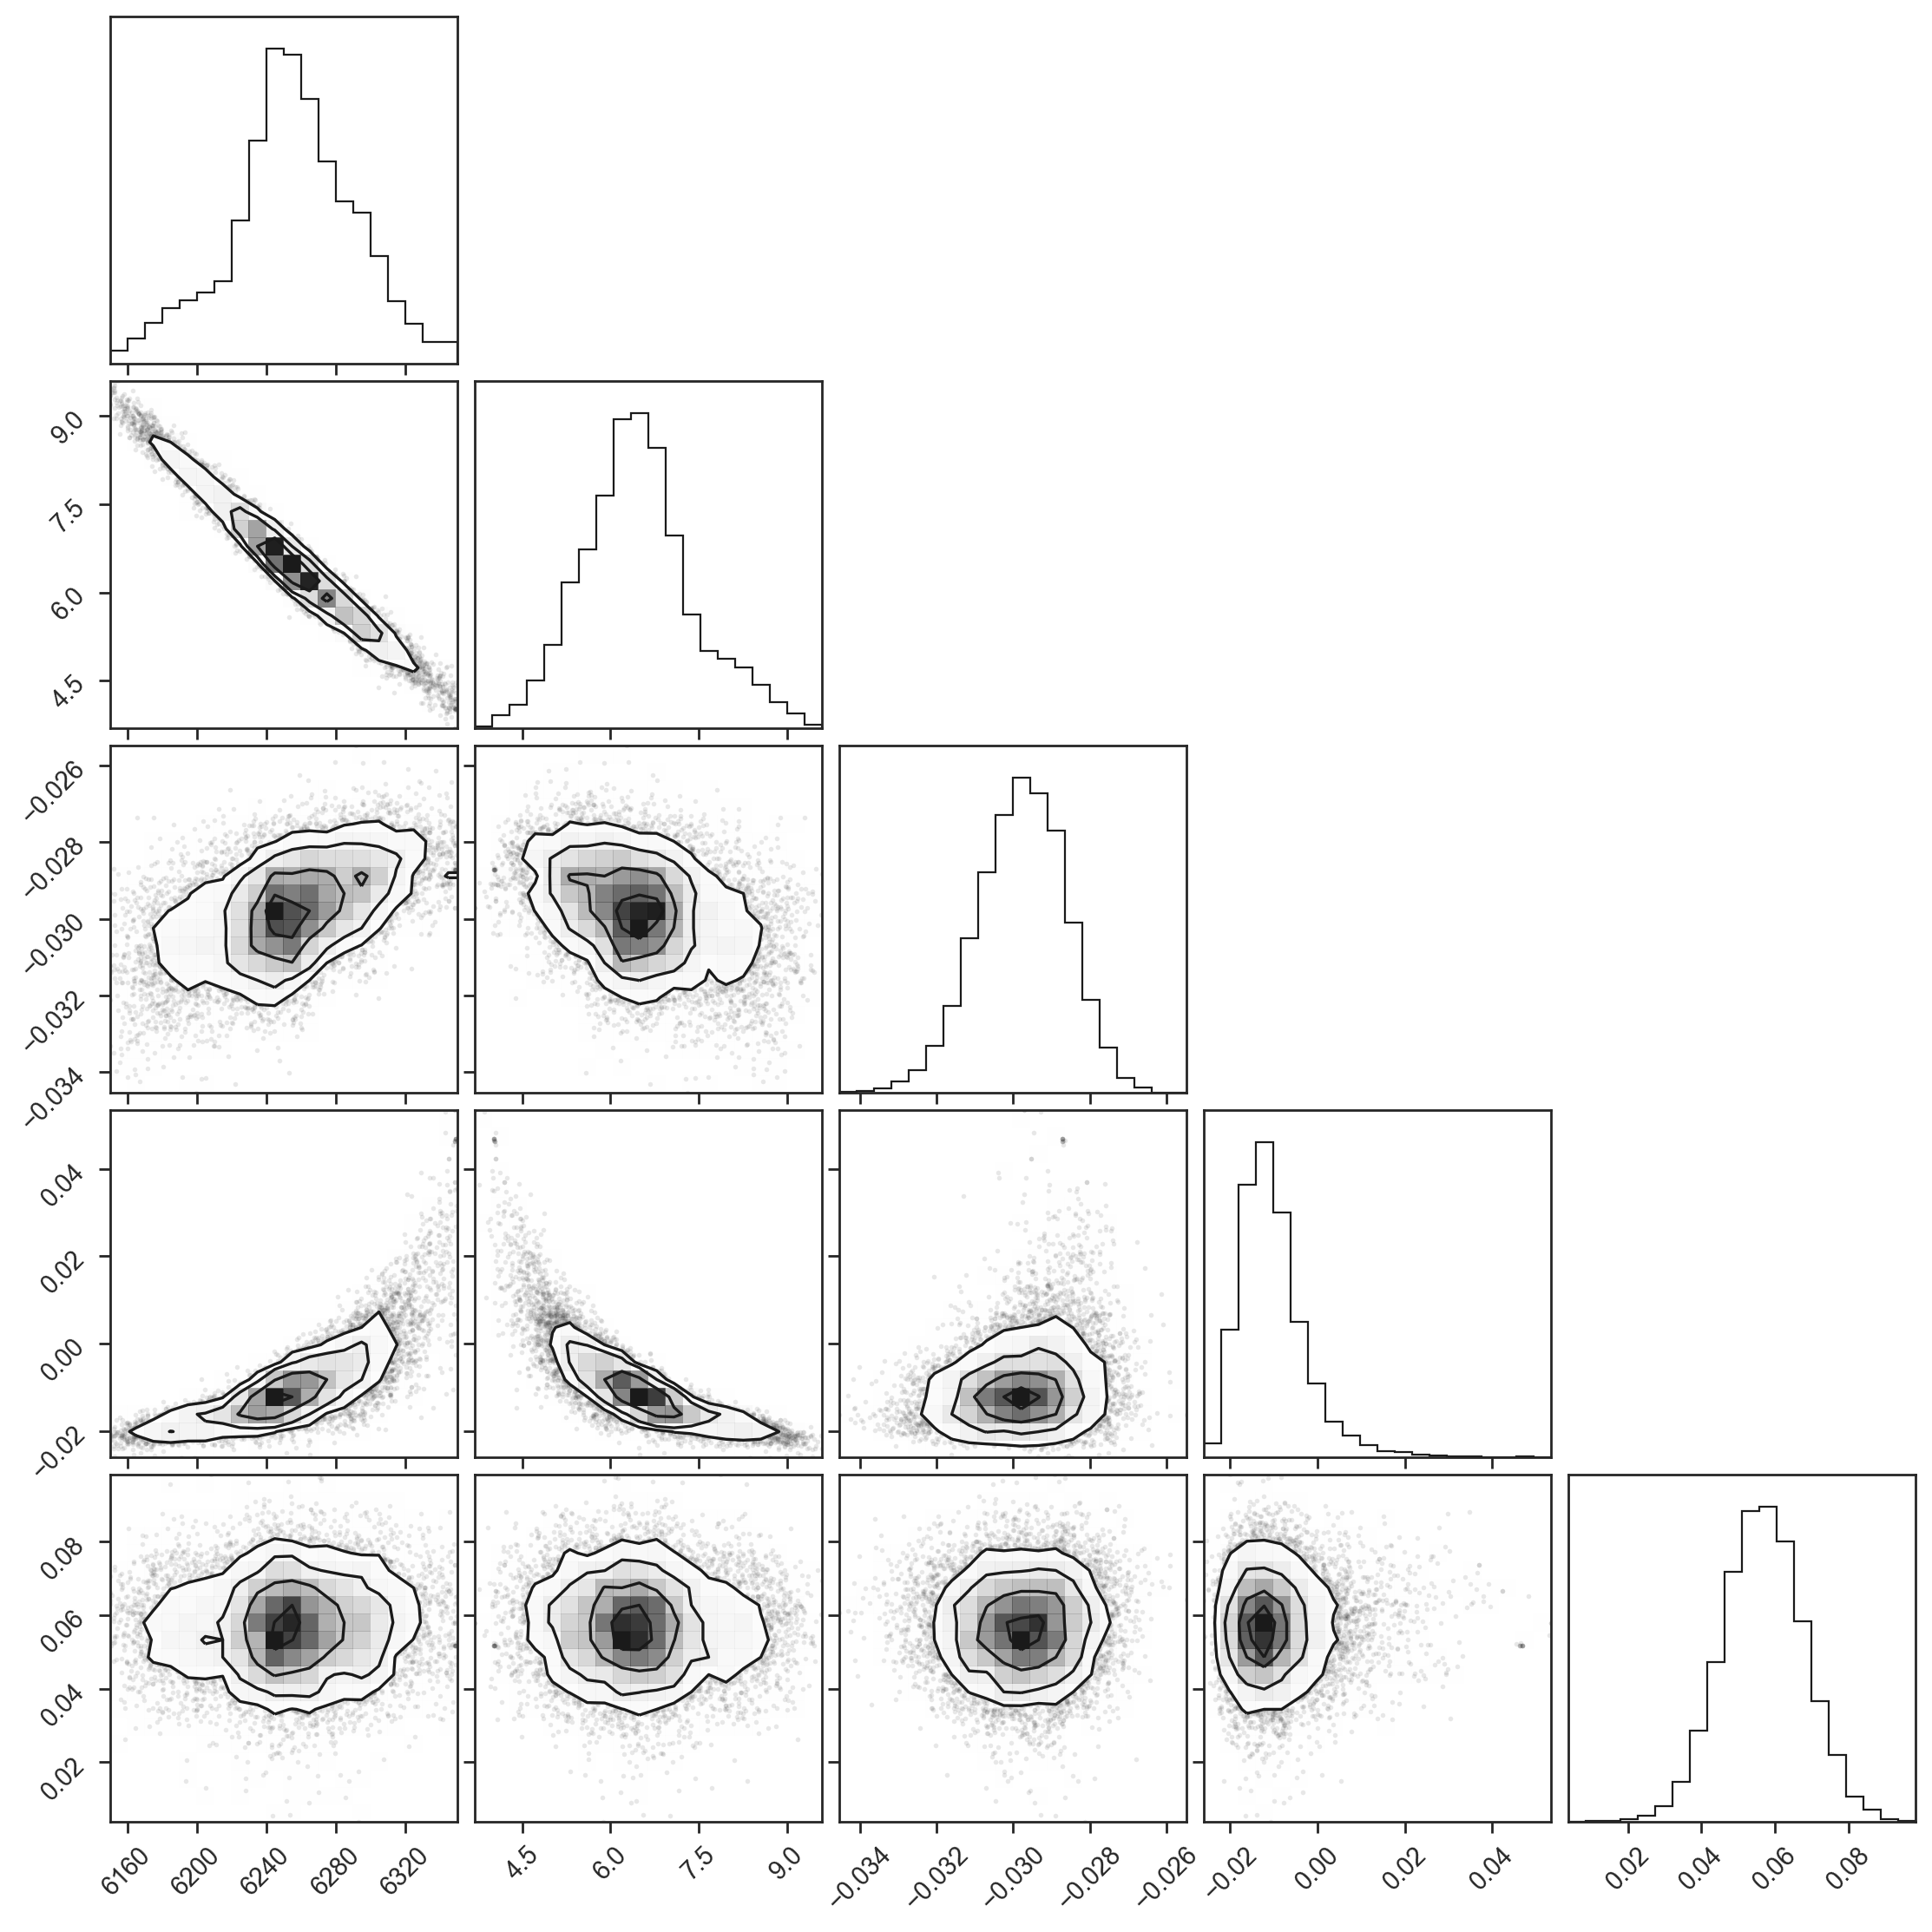

In [653]:
import corner

fig = corner.corner(
    flat_samples, #labels=labels,
);

In [311]:
np.mean(flat_samples[:,0]), np.std(flat_samples[:,0])

(6249.588747798283, 31.959725824982517)

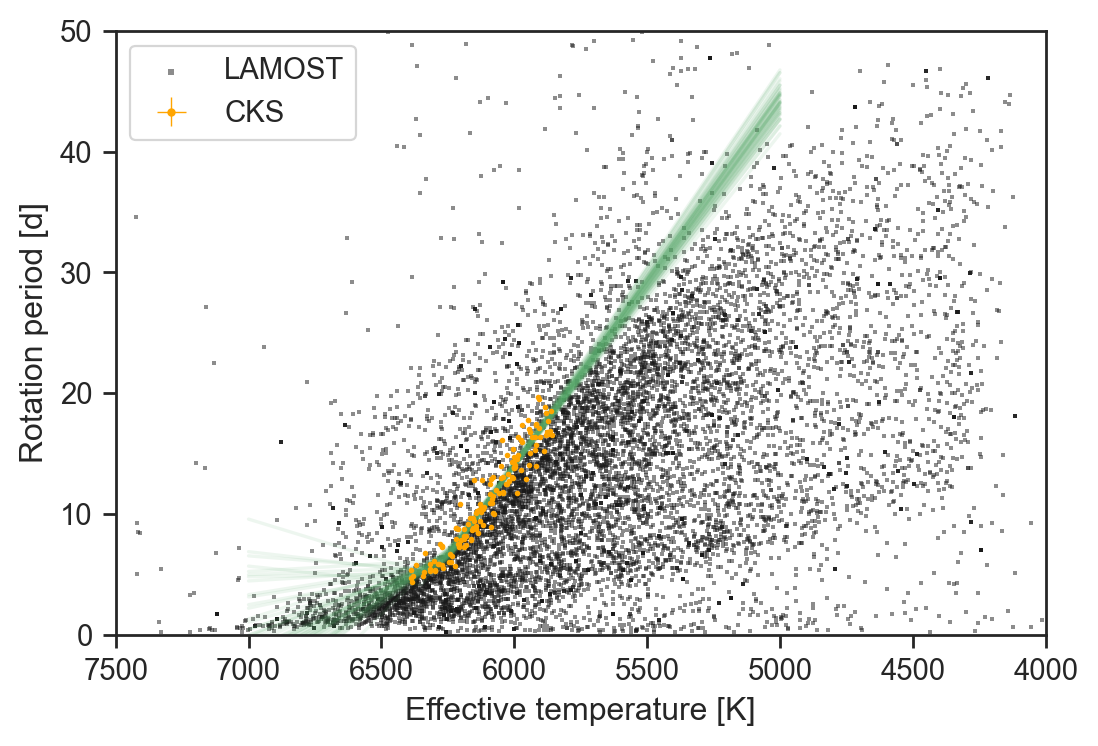

In [663]:
inds = np.random.randint(len(flat_samples), size=50)

xtmp = np.linspace(5000,7000,1000)


for ind in inds:
    sample = flat_samples[ind]
    #print(len(sample))
    plt.plot(xtmp, piecewise_linear(xtmp, sample[0], sample[1], sample[2], sample[3]), "C2", alpha=0.1)
plt.errorbar(x, y, xerr=0, yerr=yerr*np.median(flat_samples[:,4]), fmt=".", color='orange', capsize=0, lw=0.5, ms=2, label='CKS')
plt.scatter(lam_teff[ik], lam_prot[ik], s=1.5, marker=',', alpha=0.5, color="k", lw=0, label='LAMOST')
plt.xlim(7500,4000)
plt.ylim(0,50)

#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("Effective temperature [K]")
plt.ylabel("Rotation period [d]");

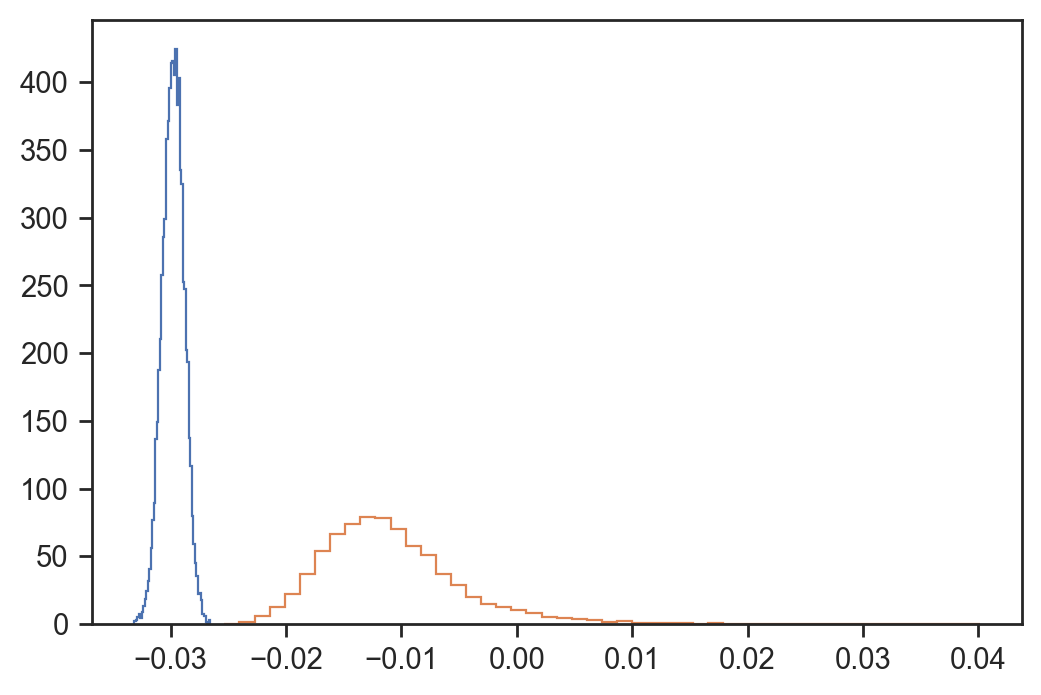

In [243]:
plt.hist(flat_samples[:,2], histtype='step', bins=50, density=True)
plt.hist(flat_samples[:,3], histtype='step', bins=50, density=True)
plt.show()

In [244]:
slope_loteff = np.median(flat_samples[:,2])
slope_hiteff = np.median(flat_samples[:,3])
eslope_loteff = np.std(flat_samples[:,2])
eslope_hiteff = np.std(flat_samples[:,3])

print((slope_hiteff-slope_loteff)/(eslope_hiteff))
print((slope_hiteff-slope_loteff)/(eslope_loteff))

2.965771917521844
19.10106132602186


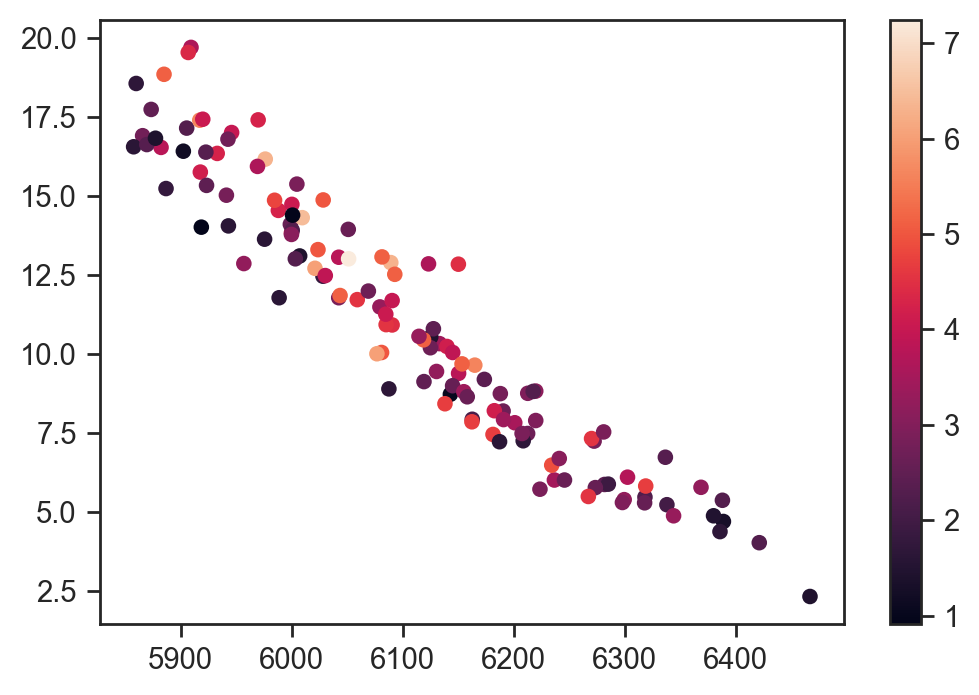

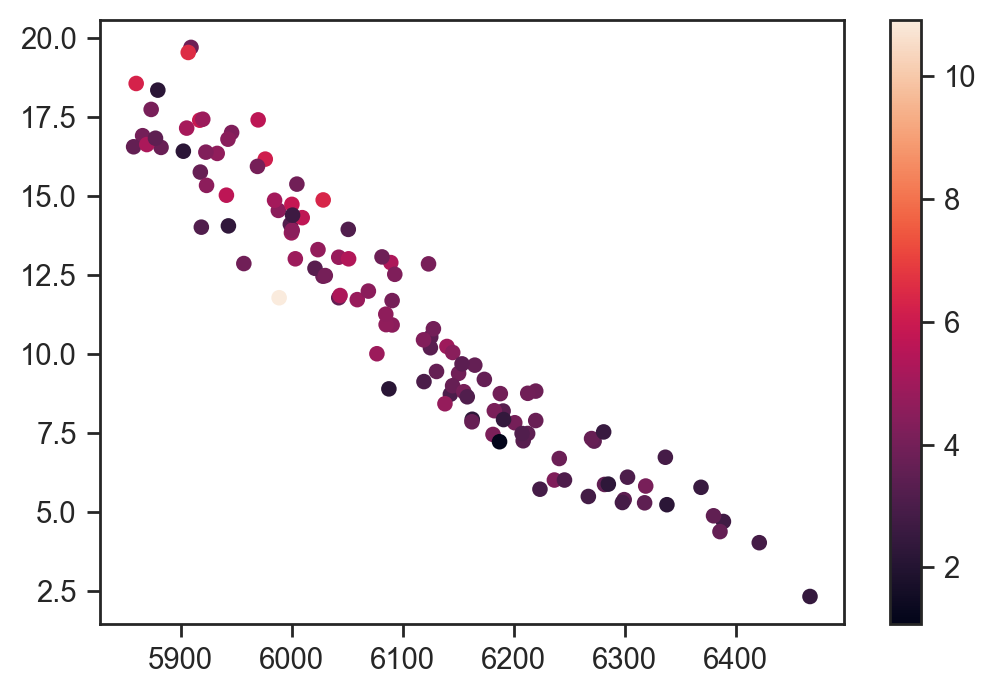

In [310]:
plt.scatter(cks_teff[ridge], cks_prot[ridge], c=cks['cks_age'][ridge])
plt.colorbar()
plt.show()

plt.scatter(cks_teff[ridge], cks_prot[ridge], c=cks['bf18_Age'][ridge])
plt.colorbar()
plt.show()

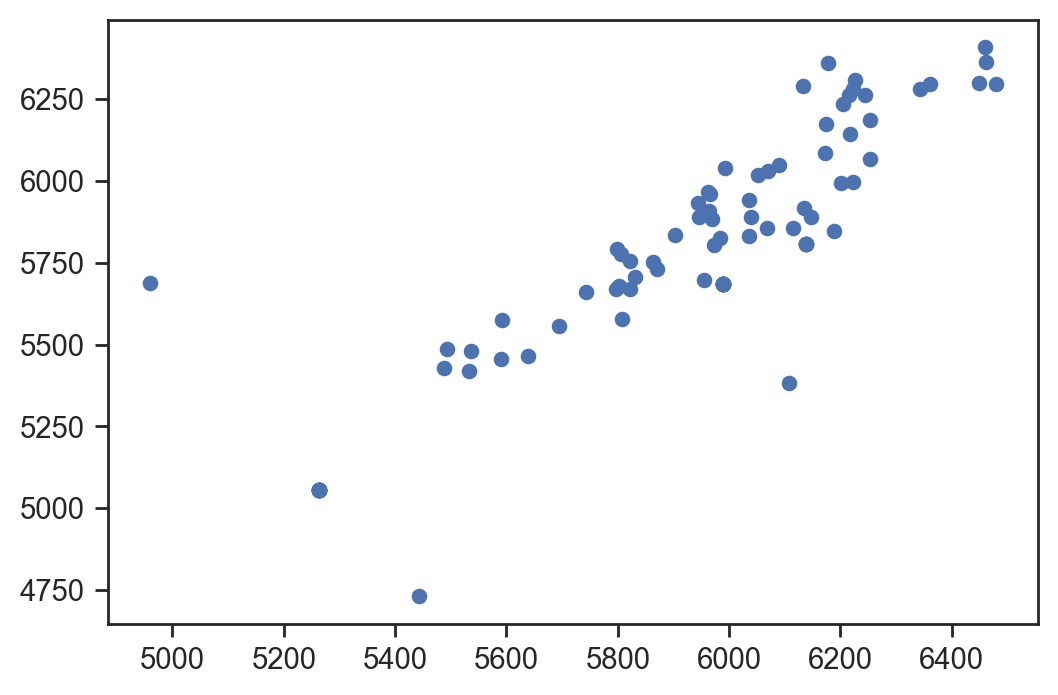

In [671]:
plt.scatter(lam["Teff_lam"], lam["apo_Teff"])
plt.show()

In [675]:
for c in gk.columns:
    print(c)

solution_id
designation
source_id
random_index
gaia_ref_epoch
ra
ra_error
dec
dec_error
parallax
parallax_error
parallax_over_error
pmra
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g_mean_flux
phot_g_mean_flux_error
phot_g_mean_flux_over_error
phot_g_mean_mag
phot_bp_n_obs
phot_bp_mean_flux
phot_bp_mean_flux_error
phot_bp_mean_flux_over_error
phot_bp_me

In [676]:
df = mcq.merge(gk, how='left', left_on='mcq_KIC', right_on='kepid')

mcq_KIC  mcq_Teff  mcq_log(g)  mcq_Mass  mcq_Prot  mcq_e_Prot  \
0        892376      3813        4.47    0.4699     1.532       0.007   
1       1026146      4261        4.57    0.6472    14.891       0.120   
2       1026474      4122        4.56    0.5914     1.569       0.006   
3       1162635      3760        4.77    0.4497    15.678       0.019   
4       1164102      4045        4.62    0.5606    31.496       0.474   
...         ...       ...         ...       ...       ...         ...   
34025  12934465      4714        4.88    0.7591    34.910       1.692   
34026  12934525      5278        4.72    0.9062    25.101       0.240   
34027  12934557      5341        4.58    0.9227    31.226       0.729   
34028  12984138      4960        4.57    0.8239    12.059       0.038   
34029  12984214      5267        3.82    0.9034     7.566       0.010   

       mcq_Rper  mcq_LPH   mcq_w  mcq_Ref mcq_n_Prot  
0       7306.69    0.823  0.4503        0        NaN  
1      11742.56    1.405  0.7229        0        NaN  
2      30471.80    1.204  0.6061        0        NaN  
3      10207.47    0.978  0.5445        1        NaN  
4       5139.74    0.568  0.3939        0        NaN  
...         ...      ...     ...      ...        ...  
34025   4572.33    0.433  0.2969        0        NaN  
34026   5150.14    0.573  0.4144        0        NaN  
34027   1889.88    0.401  0.2511        0        NaN  
34028  11734.90    1.194  0.6442        0        NaN  
34029   3887.65    1.003  0.5465        0        NaN  

[34030 rows x 11 columns]

In [677]:
gk['kepid']

0           757076
1           757099
2           757137
3           757280
4           757450
            ...   
201307    12984227
201308    12984288
201309    12984307
201310    12984404
201311    12984422
Name: kepid, Length: 201312, dtype: int64

In [762]:
#From APW
#from astropy.table import Table
apo = Table.read('../data/allStarLite-Kepler.fits')
apo.info()
print(len(apo))

<Table masked=True length=22696>
              name                dtype   shape        unit       n_bad
-------------------------------- -------- ----- ----------------- -----
                       APOGEE_ID  bytes18                             0
                       TELESCOPE   bytes8                             0
                           FIELD  bytes16                             0
                               J  float32                             0
                           J_ERR  float32                             0
                               H  float32                             0
                           H_ERR  float32                             0
                               K  float32                             0
                           K_ERR  float32                             0
                              RA  float64                             0
                             DEC  float64                             0
                            GLO

In [763]:
#McQuillan et al. 2014
mcq = Table.read('../data/mcquillan2014/table1.dat',
                readme='../data/mcquillan2014/ReadMe',
                format='ascii.cds')

for cname in mcq.colnames:
    mcq.rename_column(cname, 'mcq_'+cname)
    
    
mcq.rename_column("mcq_KIC", "kepid")
mcq.info()

<Table length=34030>
   name     dtype      unit                                 description                                class     n_bad
---------- ------- ------------ ------------------------------------------------------------------- ------------ -----
     kepid   int64                                     Kepler Input Catalog identifier (Cat. V/133)       Column     0
  mcq_Teff   int64            K                              [3197/6499] Star effective temperature       Column     0
mcq_log(g) float64 dex(cm / s2)                                [3.5/5.4] Star surface gravity (log)       Column     0
  mcq_Mass float64         Msun                                             [0.2/1.3] Star mass (1)       Column     0
  mcq_Prot float64            d                                           [0.2/70]? Rotation period       Column     0
mcq_e_Prot float64            d                                               [0/51]? Error in Prot       Column     0
  mcq_Rper float64         

In [764]:
from astropy.table import join
apok = join(apo, mcq, keys=["kepid"], join_type="inner")

In [765]:
apok.colnames

['APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE_TARGET3',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NINST',
 'NVISITS',
 'COMBTYPE',
 'COMMISS',
 'SNR',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'VERR_MED',
 'OBSVHELIO_AVG',
 'OBSVSCATTER',
 'OBSVERR',
 'OBSVERR_MED',
 'SYNTHVHELIO_AVG',
 'SYNTHVSCATTER',
 'SYNTHVERR',
 'SYNTHVERR_MED',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'SYNTHSCATTER',
 'STABLERV_CHI2',
 'STABLERV_RCHI2',
 'CHI2_THRESHOLD',
 'STABLERV_CHI2_PROB',
 'MEANFIB',
 'SIGFIB',
 'SNREV',
 'APSTAR_VERSION',
 'ASPCAP_VERSION',
 'RESULTS_VERSION',
 'EXTRATARG',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'TEFF',
 'TEFF_ERR',
 'LOGG',
 'LOGG_ERR',
 'VMICRO',
 'VMACRO',
 'VSINI',
 'M_H',
 'M_H_ERR',
 'ALP

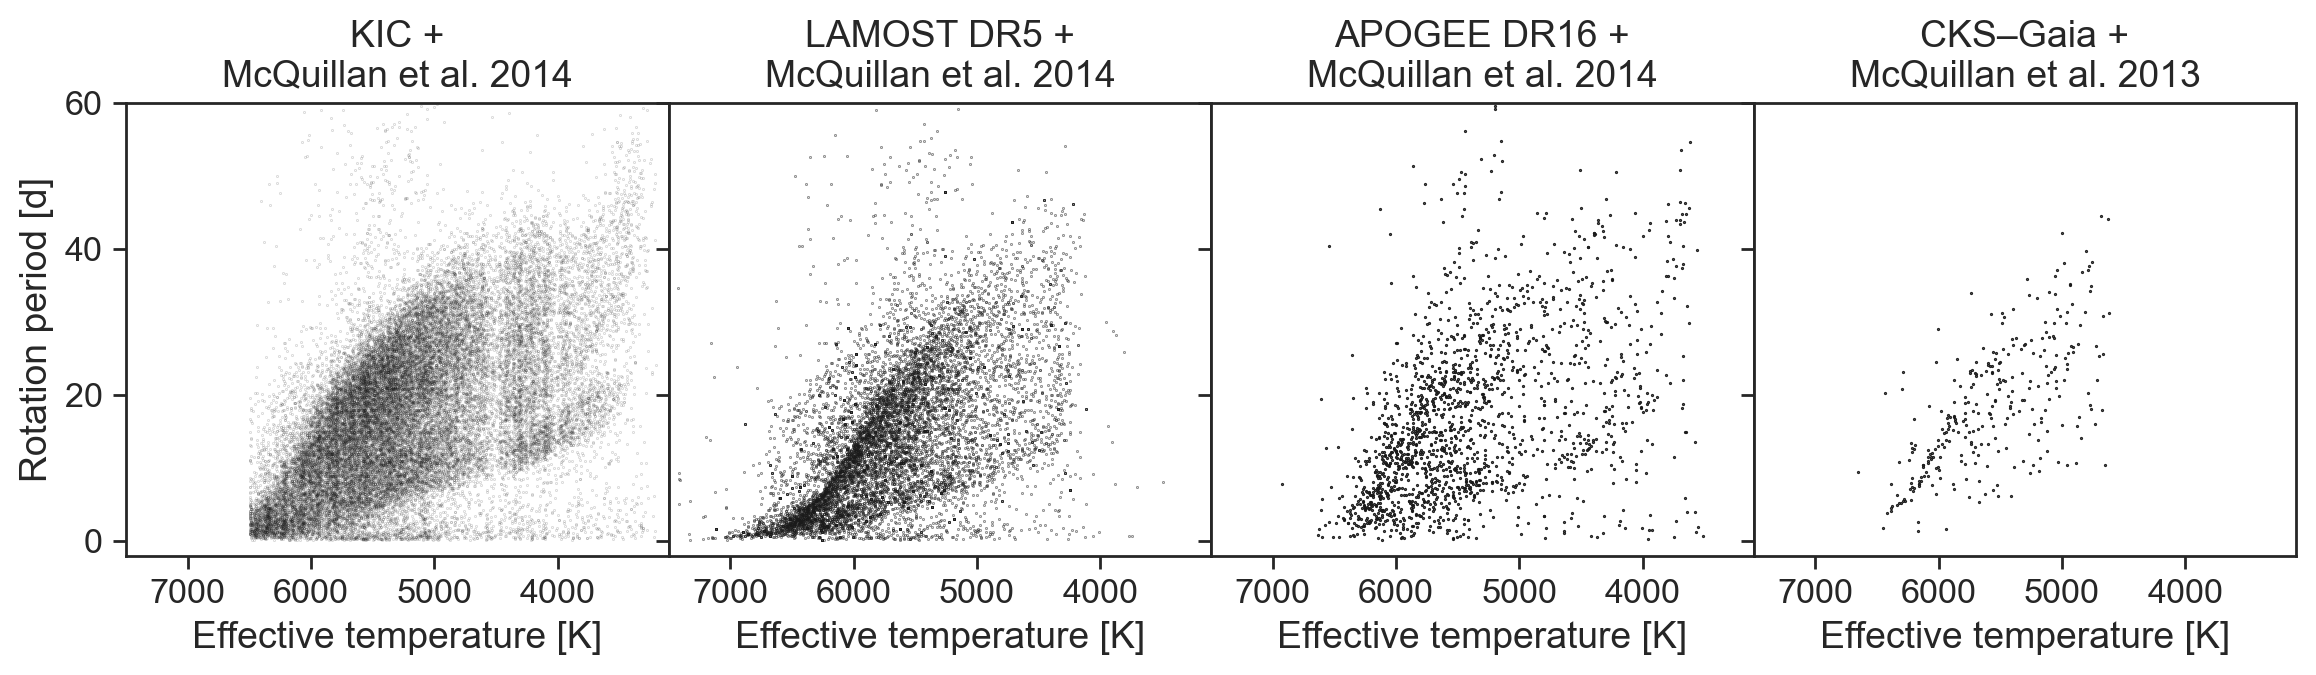

In [835]:
sns.set(font_scale=1.4, context="paper", style="ticks")

sc_kws = {"marker":".", "alpha": 1, "rasterized":True, "color":"k"}

titles=['KIC +\nMcQuillan et al. 2014', 
        'LAMOST DR5 +\nMcQuillan et al. 2014', 
        'APOGEE DR16 +\nMcQuillan et al. 2014', 
        'CKS–Gaia +\nMcQuillan et al. 2013']

fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(14,3))

ax[0].scatter(mcq["mcq_Teff"], mcq["mcq_Prot"], **sc_kws, s=0.01)
ax[1].scatter(lam["Teff_lam"][ik], lam["mcq_Prot"][ik], **sc_kws, s=0.1)
ax[2].scatter(apok["TEFF"], apok["mcq_Prot"], **sc_kws, s=0.5)
#ax[2].scatter(apok["TEFF"][arg], apok["mcq_Prot"][arg], **sc_kws, s=0.5)
ax[3].scatter(cks["cks_Teff"], cks["mcq_Prot"], **sc_kws, s=0.5)

for i in range(4):
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("Effective temperature [K]")        
    ax[i].set_xlim(7500,3100)
    ax[i].set_ylim(-2,60)
    if i>0:
        ax[i].set_yticklabels([])
    

ax[0].set_ylabel("Rotation period [d]")    
plt.subplots_adjust(wspace=0)
plt.savefig('../figures/surveys.pdf')
plt.show()

In [760]:
#arg = (apok["LOGG"]>4)
#arg &= (apok["SNR"]>np.nanmedian(apok["SNR"]))

In [751]:
apok.colnames

['APOGEE_ID',
 'TELESCOPE',
 'FIELD',
 'J',
 'J_ERR',
 'H',
 'H_ERR',
 'K',
 'K_ERR',
 'RA',
 'DEC',
 'GLON',
 'GLAT',
 'APOGEE_TARGET1',
 'APOGEE_TARGET2',
 'APOGEE_TARGET3',
 'APOGEE2_TARGET1',
 'APOGEE2_TARGET2',
 'APOGEE2_TARGET3',
 'TARGFLAGS',
 'SURVEY',
 'PROGRAMNAME',
 'NINST',
 'NVISITS',
 'COMBTYPE',
 'COMMISS',
 'SNR',
 'STARFLAG',
 'STARFLAGS',
 'ANDFLAG',
 'ANDFLAGS',
 'VHELIO_AVG',
 'VSCATTER',
 'VERR',
 'VERR_MED',
 'OBSVHELIO_AVG',
 'OBSVSCATTER',
 'OBSVERR',
 'OBSVERR_MED',
 'SYNTHVHELIO_AVG',
 'SYNTHVSCATTER',
 'SYNTHVERR',
 'SYNTHVERR_MED',
 'RV_TEFF',
 'RV_LOGG',
 'RV_FEH',
 'RV_ALPHA',
 'RV_CARB',
 'RV_CCFWHM',
 'RV_AUTOFWHM',
 'SYNTHSCATTER',
 'STABLERV_CHI2',
 'STABLERV_RCHI2',
 'CHI2_THRESHOLD',
 'STABLERV_CHI2_PROB',
 'MEANFIB',
 'SIGFIB',
 'SNREV',
 'APSTAR_VERSION',
 'ASPCAP_VERSION',
 'RESULTS_VERSION',
 'EXTRATARG',
 'MIN_H',
 'MAX_H',
 'MIN_JK',
 'MAX_JK',
 'TEFF',
 'TEFF_ERR',
 'LOGG',
 'LOGG_ERR',
 'VMICRO',
 'VMACRO',
 'VSINI',
 'M_H',
 'M_H_ERR',
 'ALP

(array([ 272., 1073.,  334.,   76.,   39.,   15.,    5.,    2.,    2.,
           2.]),
 array([1.06922e-10, 9.95500e+01, 1.99100e+02, 2.98650e+02, 3.98200e+02,
        4.97750e+02, 5.97300e+02, 6.96850e+02, 7.96400e+02, 8.95950e+02,
        9.95500e+02], dtype=float32),
 <BarContainer object of 10 artists>)

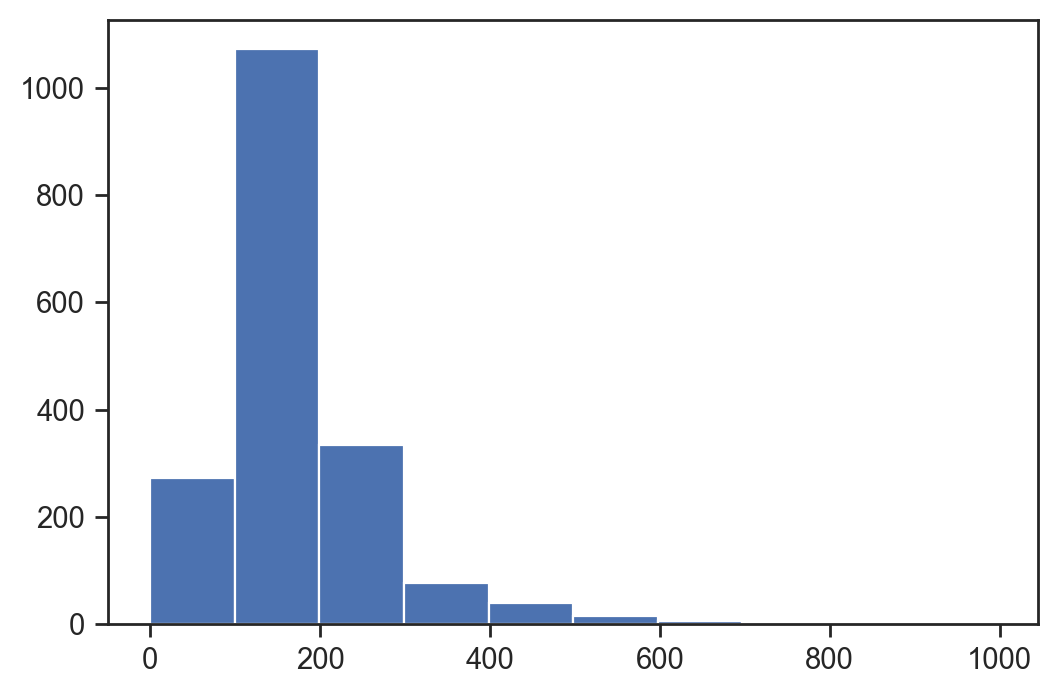

In [752]:
plt.hist(apok["SNR"])

In [780]:
for col in lam.columns:
    print(col)

DR2Name
KIC
RA
Dec
Gmag
BP_RP
parallax_x
pmra_x
pmde
rv_gaia
erv_gaia
Prot
RV_lam
e_RV_lam
Teff_lam
e_Teff_lam
logg_lam
e_logg_lam
feh_lam
e_feh_lam
afe_lam
e_afe_lam
solution_id
designation
source_id_x
random_index
gaia_ref_epoch
ra
ra_error
dec
dec_error
parallax_y
parallax_error
parallax_over_error
pmra_y
pmra_error
pmdec
pmdec_error
ra_dec_corr
ra_parallax_corr
ra_pmra_corr
ra_pmdec_corr
dec_parallax_corr
dec_pmra_corr
dec_pmdec_corr
parallax_pmra_corr
parallax_pmdec_corr
pmra_pmdec_corr
astrometric_n_obs_al
astrometric_n_obs_ac
astrometric_n_good_obs_al
astrometric_n_bad_obs_al
astrometric_gof_al
astrometric_chi2_al
astrometric_excess_noise
astrometric_excess_noise_sig
astrometric_params_solved
astrometric_primary_flag
astrometric_weight_al
astrometric_pseudo_colour
astrometric_pseudo_colour_error
mean_varpi_factor_al
astrometric_matched_observations
visibility_periods_used
astrometric_sigma5d_max
frame_rotator_object_type
matched_observations
duplicated_source
phot_g_n_obs
phot_g

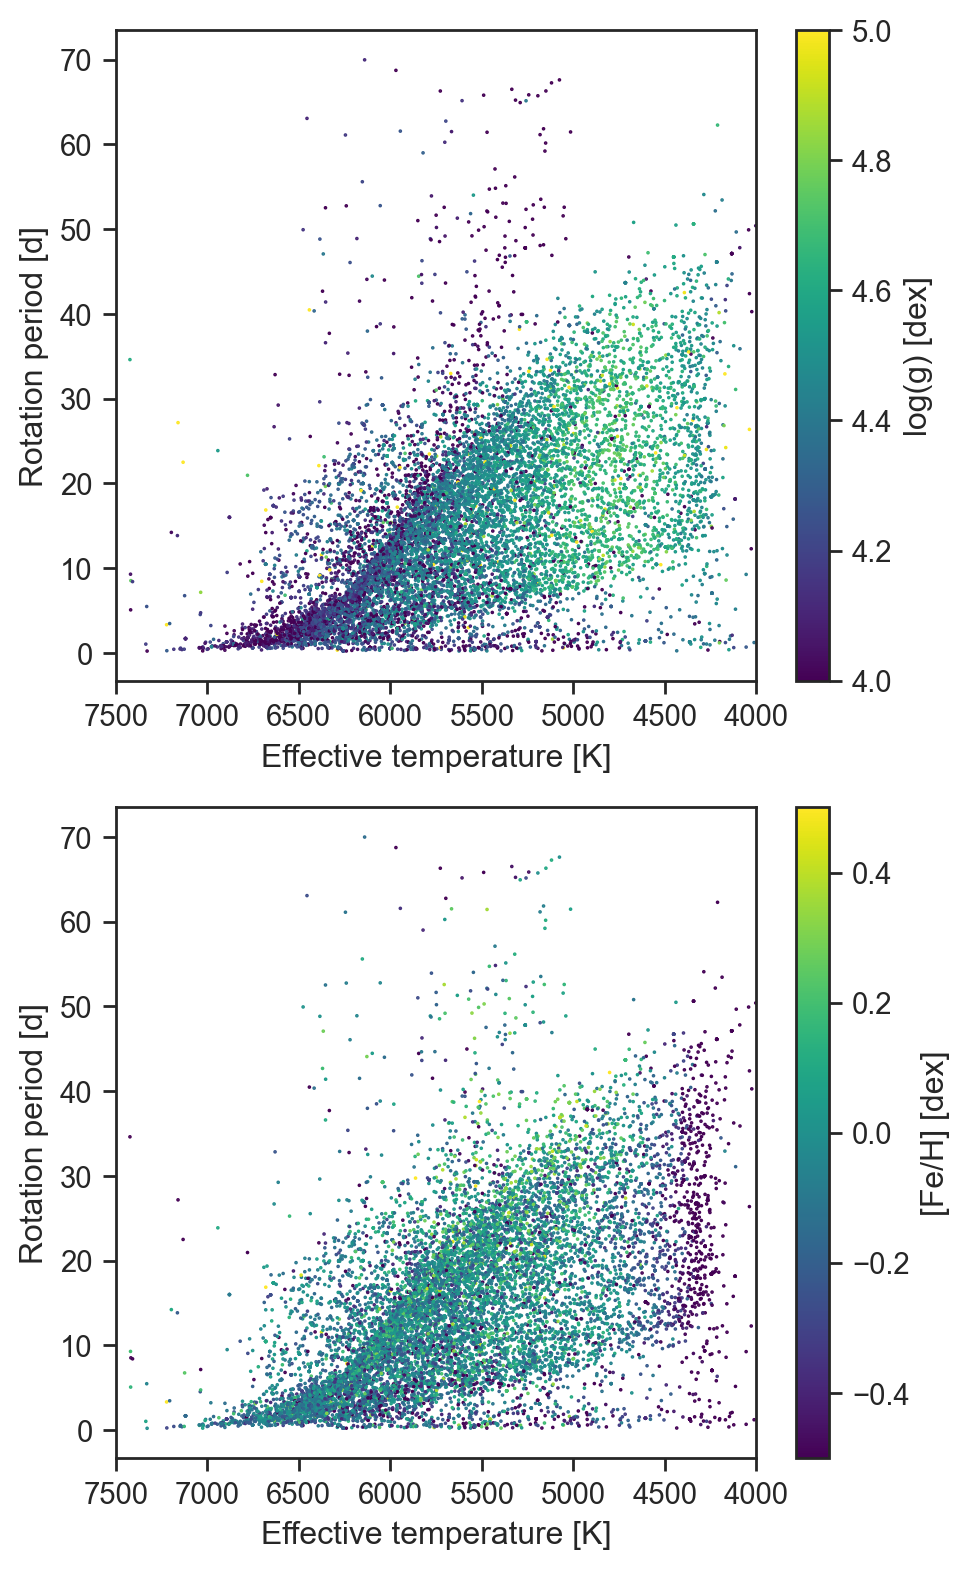

In [825]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5,8))
#order = np.argsort(lam["logg_lam"][ik])

sc1 = ax1.scatter(lam["Teff_lam"], 
                  lam["mcq_Prot"], 
                  c=lam["logg_lam"], vmin=4, vmax=5, s=0.25, cmap='viridis')

fig.colorbar(sc1, ax=ax1, label='log(g) [dex]')

sc2 = ax2.scatter(lam["Teff_lam"], 
                  lam["mcq_Prot"], 
                  c=lam["feh_lam"], vmin=-0.5, vmax=0.5, s=0.25, cmap='viridis')

fig.colorbar(sc2, ax=ax2, label='[Fe/H] [dex]')

for ax in [ax1,ax2]:
    ax.set_xlim(7500,4000)
    ax.set_xlabel('Effective temperature [K]')
    ax.set_ylabel('Rotation period [d]')


plt.tight_layout()
#plt.colorbar(, ax=ax1)    
plt.show()